- *Nombre Alumno/a*: 
- *Asignatura*: Ingeniería del Conocimiento
- *Curso*: 2022/2023
- *Profesor*: Fco. Javier Martínez de Pisón
- Universidad de La Rioja

# Proyecto 3. Parte 1. Diseño de DSS en Empresa de Ventas On-Line: Clasificador Binario de la Clase 2

Vamos a desarrollar clasificadores trabajando con la base de datos de la competicion de Kaggle [Otto Group Product Classification](https://www.kaggle.com/c/otto-group-product-classification-challenge).

Otto Group es una de las mayores multinacionales de venta de comercio electrónico con empresas subsidiarias en más de 20 países del mundo. Cada día, venden millones de productos por todo el mundo incrementando continuamente la oferta con miles de productos nuevos.

Debido a la enorme cantidad de productos que se incluyen diariamente, **la empresa necesita tener un buen modelo predictivo que le ayude a clasificar cada nuevo producto en nueve grandes grupos**. Este modelo permitirá a la empresa ser mucho más eficiente en la realización de futuros trabajos como: análisis de mercado, análisis de clientes, diseño de ofertas, análisis de ventas, etc.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/4280/media/Grafik.jpg)

En este proyecto vamos a aprender a desarrollar modelos clasificadores útiles para la toma de decisiones empresariales. En particular, el objetivo es buscar buenos modelos clasificadores capaces de identificar ante un nuevo producto y una serie de características que lo describe, **a qué familia pertenece**.

Primero desarrollaremos modelos binarios y después modelos multiclase. A aprenderemos cómo realizar el ajuste de los hiperparámetros de modelos y combinarlos en modelos *Ensemble*.

In [1]:
!pip install bayesian-optimization
!pip install lightgbm
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importamos paquetes basicos
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
# from tqdm.notebook import tqdm
from tqdm.notebook import tqdm

import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier 
from sklearn.metrics import log_loss, cohen_kappa_score, accuracy_score, f1_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression

from bayes_opt import BayesianOptimization

from lightgbm.sklearn import LGBMClassifier
from xgboost.sklearn import XGBClassifier

# %matplotlib inline
plt.style.use('ggplot')
# Elimina la limitación en visualización del numero de columnas
pd.set_option('display.max_columns', None) 
%matplotlib inline

## Cargamos la Base de Datos

In [3]:
!wget https://github.com/IC1920/Datasets/raw/master/train.zip -O train.zip
!wget https://github.com/IC1920/Datasets/raw/master/test.zip -O test.zip
!unzip -o train.zip
!unzip -o test.zip

--2023-05-25 15:17:42--  https://github.com/IC1920/Datasets/raw/master/train.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IC1920/Datasets/master/train.zip [following]
--2023-05-25 15:17:42--  https://raw.githubusercontent.com/IC1920/Datasets/master/train.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1655239 (1.6M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]   1.58M  --.-KB/s    in 0.03s   

2023-05-25 15:17:43 (51.2 MB/s) - ‘train.zip’ saved [1655239/1655239]

--2023-05-25 15:17:43--  https://github.com/IC1920/Datasets/raw/master/test

Para reducir los tiempos de entrenamiento y, por fines didácticos, **vamos a crear tres bases de datos a partir de la base de datos de entrenamiento original**: una de entrenamiento, otra de validación para ajustar los hiperparámetros y una final de testeo para verificar el grado de generalización del modelo elegido. Las mismas se van a realizar mediante **muestreo estratificado**, es decir, la el target de cada base de datos va a tener la misma distribución de clases. Lo ideal sería utilizar un alto porcentaje de la BD para entrenar (por ejemplo un 80%) o usar validación cruzada (incluso repetida), pero para acelerar el proceso de entrenamiento vamos a reducir el tamaño de la base de datos de entrenamiento. Nota: es posible que los modelos mejoren si se entrenan con más datos...

La base de datos original está disponible en https://www.kaggle.com/c/otto-group-product-classification-challenge, con más de 65.000 instancias. Es importante destacar que las variables han sido anonimizadas por la empresa y no se dispone de su descripción real. 

---

**Para profundizar los siguientes videos**: 

- *Stratified Sampling to Split Train Test Validation Data | Machine Learning*: https://www.youtube.com/watch?v=ixBbAZDS7TU
- *Sampling: Population vs. Sample, Random Sampling, Stratified Sampling*: https://www.youtube.com/watch?v=r-rFO_2NsgI

---

In [4]:
# Leemos los archivos 
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print(df_train.shape, df_test.shape)

features = ['feat_'+str(i) for i in np.arange(1,94)]
target = 'target'

(61878, 95) (144368, 94)


In [5]:
df_train.columns

Index(['id', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30',
       'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36',
       'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42',
       'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48',
       'feat_49', 'feat_50', 'feat_51', 'feat_52', 'feat_53', 'feat_54',
       'feat_55', 'feat_56', 'feat_57', 'feat_58', 'feat_59', 'feat_60',
       'feat_61', 'feat_62', 'feat_63', 'feat_64', 'feat_65', 'feat_66',
       'feat_67', 'feat_68', 'feat_69', 'feat_70', 'feat_71', 'feat_72',
       'feat_73', 'feat_74', 'feat_75', 'feat_76', 'feat_77', 'feat_78',
       'feat_79', 'feat_80', 'feat_81', 'feat_82', 'fe

In [6]:
# Realizamos un Muestreo Estratificado con 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
# Convertimos a números las clases (0 a 8)
df_train['target_num'] = df_train['target'].map(dict(zip(df_train.target.unique(),np.arange(len(df_train.target.unique())))))
df_train['kfold'] = 0
for nfold, (_, fold_index) in enumerate(skf.split(df_train, df_train.target)):
    df_train.loc[fold_index, 'kfold'] = nfold

df_train_reduc = df_train[df_train['kfold']<4].reset_index(drop=True)    
df_valid_reduc = df_train[df_train['kfold'].isin([4,5,6])].reset_index(drop=True)
df_test_reduc = df_train[df_train['kfold']>6].reset_index(drop=True)
print(df_train_reduc.shape, df_valid_reduc.shape, df_test_reduc.shape)

(24752, 97) (18564, 97) (18562, 97)


## AED Básico

La base de datos está anonimizada por la empresa y ya preprocesada por lo que realizaremos un AED muy sencillo.

In [ ]:
df_train_reduc.sample(5)

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target,target_num,kfold
12278,30670,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,38,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,Class_5,4,1
974,2405,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,3,0,0,0,0,0,0,0,1,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_2,1,0
146,374,0,0,0,0,0,0,0,6,0,0,0,1,2,1,0,0,1,2,0,1,0,0,0,6,0,0,0,0,1,0,0,0,0,0,0,11,0,1,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,6,0,0,0,1,0,0,1,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,2,0,0,Class_1,0,2
21473,53676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,Class_8,7,3
10719,26778,1,0,0,1,0,0,0,0,0,2,0,0,0,1,19,4,0,0,0,0,0,1,0,0,3,3,0,0,0,0,0,0,1,0,2,0,0,1,2,1,1,1,0,0,0,0,0,0,1,0,0,0,0,6,1,0,0,0,0,3,0,1,1,1,1,1,0,0,1,1,1,5,0,0,0,0,0,1,0,0,0,0,0,0,3,5,1,0,0,0,0,0,0,Class_4,3,3


In [ ]:
np.unique(df_train.dtypes,return_counts=True)

(array([dtype('int64'), dtype('O')], dtype=object), array([96,  1]))

Tenemos, además del 'id' de cada producto, 93 características anónimas del tipo entero 64. Según la descripción de Kaggle los atributos representan el conteo de diferentes eventos.

El *target*, representa 9 clases con la siguiente distribución (la base de datos de testeo lógicamente no tiene *target*).

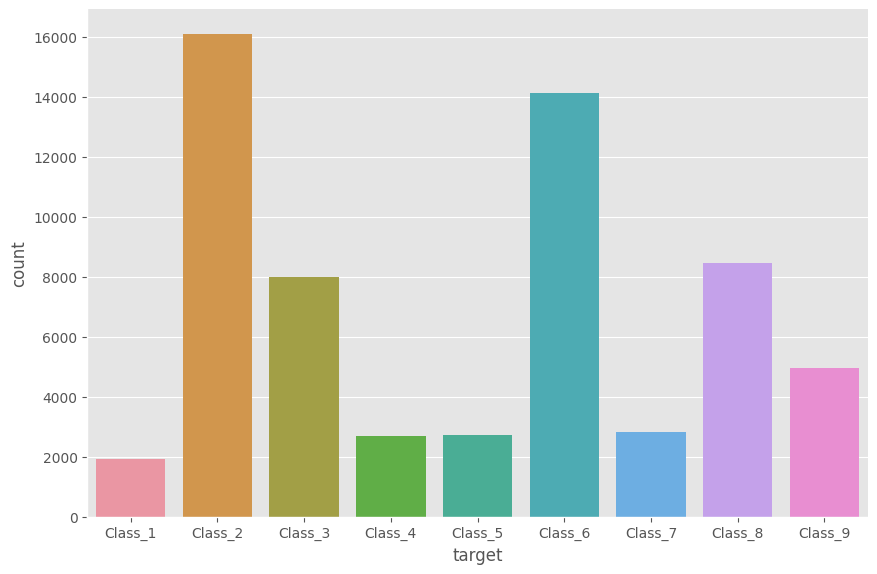

In [ ]:
g = sns.catplot(x='target',data=df_train,kind="count")
g.fig.set_size_inches(10,6)
 #df_train['target'].value_counts()

In [ ]:
df_test.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,3,2,1,0,0,0,0,0,0,0,5,3,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,11,1,20,0,0,0,0,0
1,2,2,2,14,16,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,2,0,4,0,4,0,0,0,0,2,0,0,0,8,0,0,0,0,0,0,0,0,2,0,4,0,4,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,6,8,0,0,0,0,0,0,0,0,0,0,0,2,0,0,4,0,2,0,0,0,0,0,0,4,0,0,2,0
2,3,0,1,12,1,0,0,0,0,0,0,7,1,0,0,0,7,0,2,0,0,0,4,0,0,0,1,1,2,0,0,0,0,0,0,1,0,0,2,0,0,0,1,0,1,0,4,0,2,3,0,0,0,0,10,1,0,2,0,0,1,6,1,1,0,0,1,1,1,2,0,0,2,0,0,0,0,0,0,0,6,0,2,0,0,0,0,0,2,0,0,0,0,1
3,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,21,3,0,0,0,0,0,0,0,0,4,0,0,0,1,0,0,0,2,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,9,0,0,2,0,0,0,0,6,0,8,0,0,0,0,1,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0
4,5,1,0,0,1,0,0,1,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,4,0,5,16,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9,0,0


Tanto en la base de datos de testeo como la de entrenamiento vemos que los valores son muy dispersos (sparse), con un elevado número de ceros.

In [ ]:
np.unique(df_train[features].values.flatten(),return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 119, 121, 123, 125, 127, 130, 131, 132, 137, 139, 145, 148,
        149, 158, 160, 161, 165, 170, 171, 172, 180, 181, 231, 252, 253,
        263, 281, 283, 287, 311, 323, 325, 352]),
 array([4565838,  595789,  227816,  106951,   66006,   40568,   30343,
          22321,   17639,   13326,   11271,    8394,    7670,    5740,
     

Visualizamos en un boxplot cada feature según las clases de salida. En este caso, fijamos el limite superior a 15 para ver con más detenimiento los diagramas de cajas.

  0%|          | 0/93 [00:00<?, ?it/s]

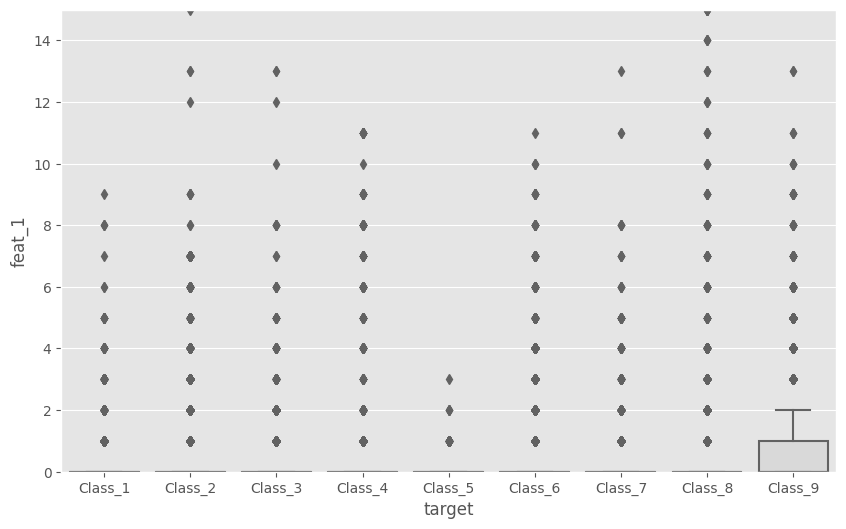

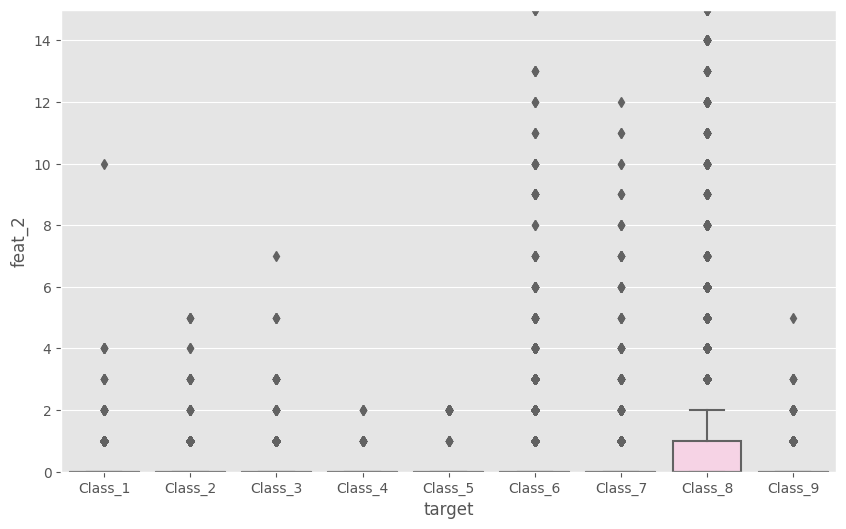

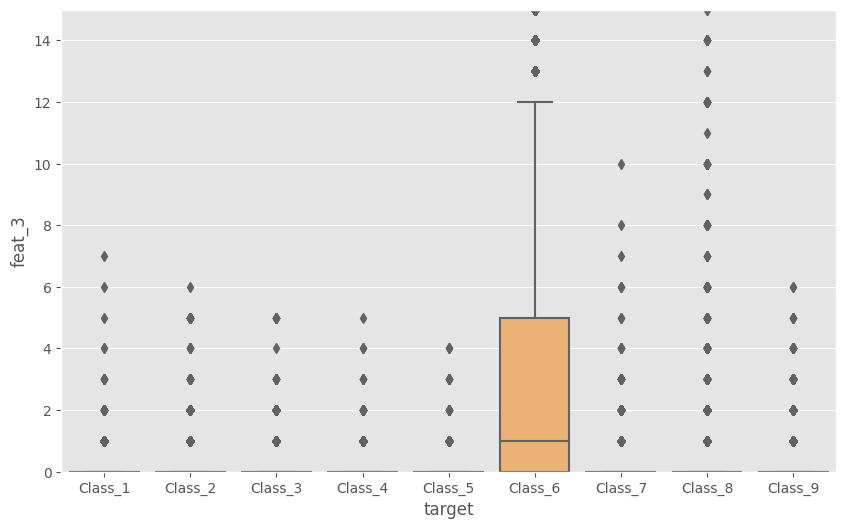

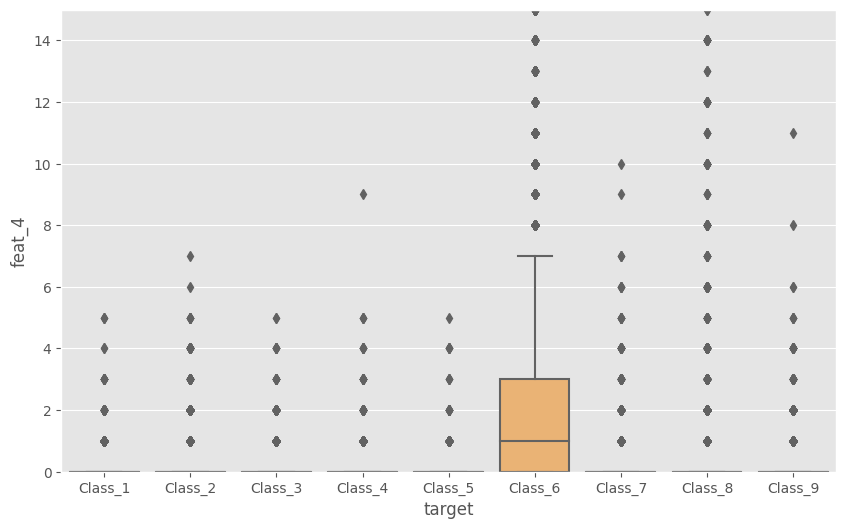

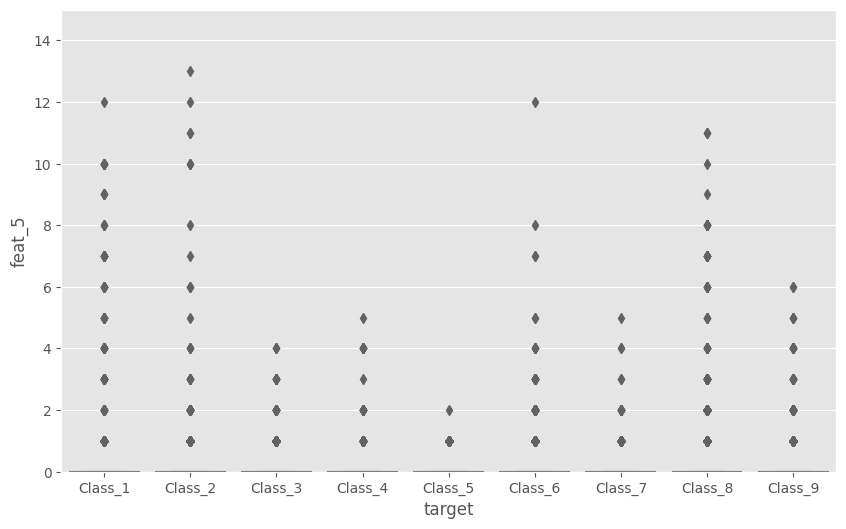

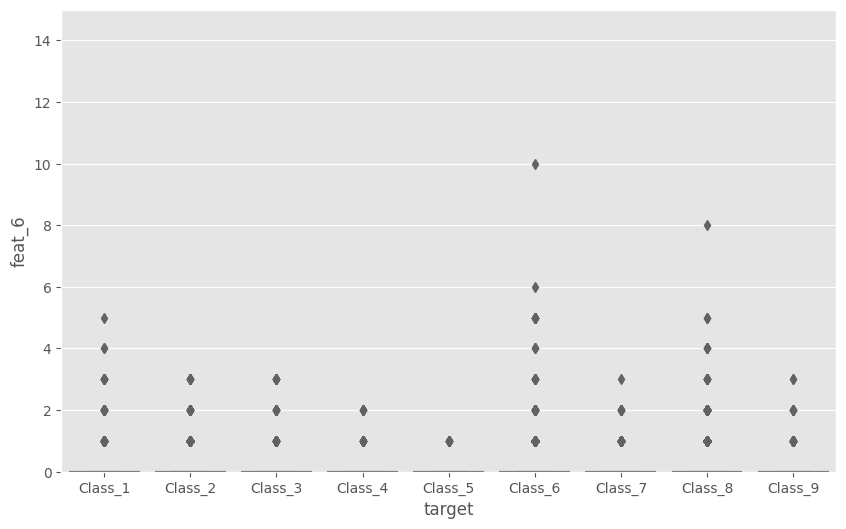

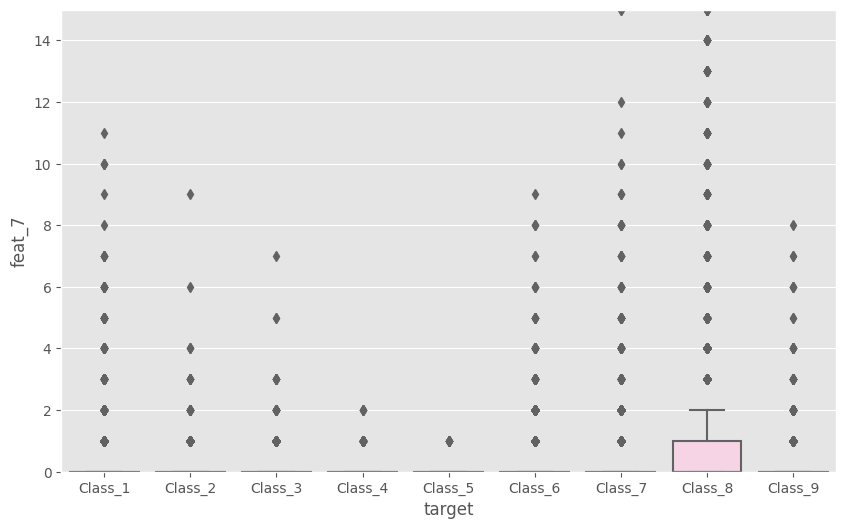

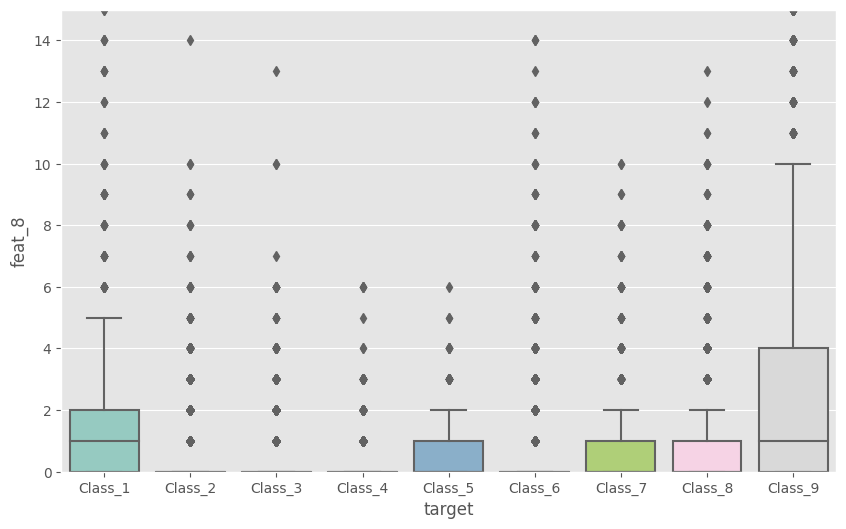

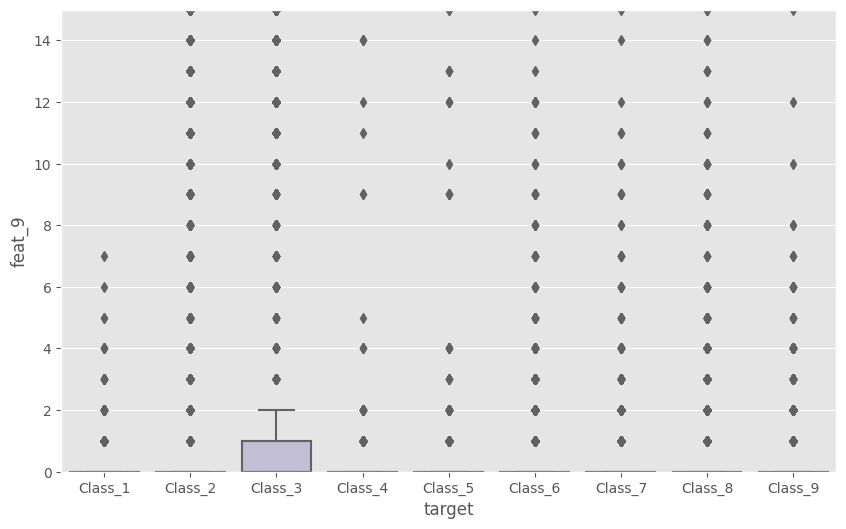

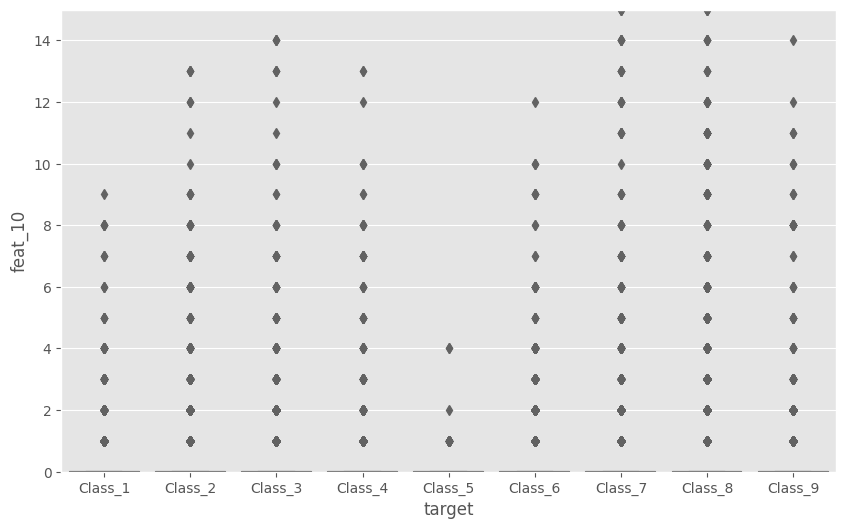

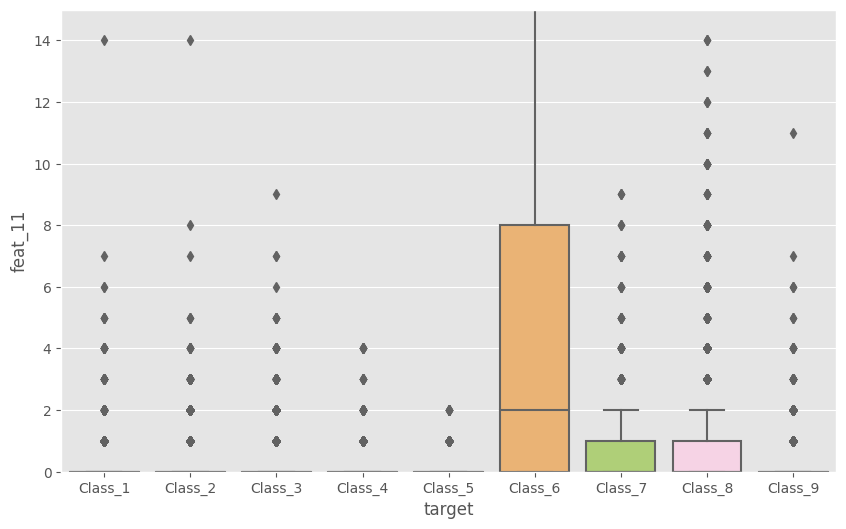

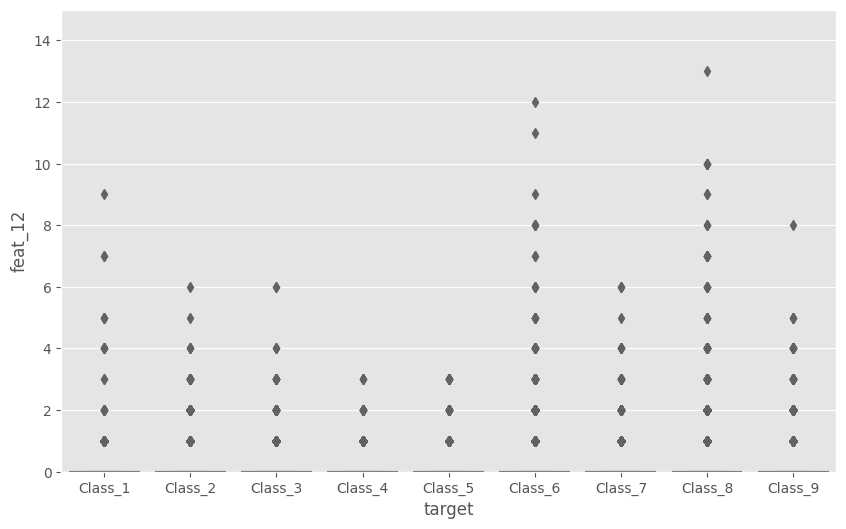

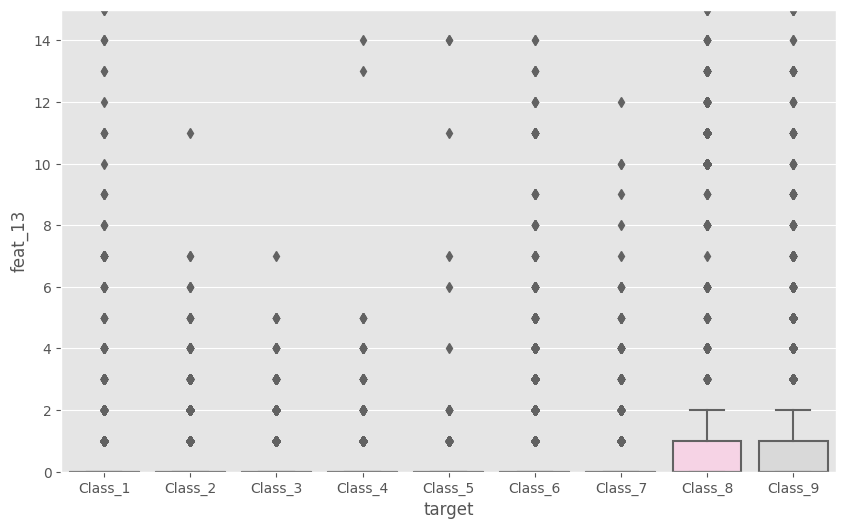

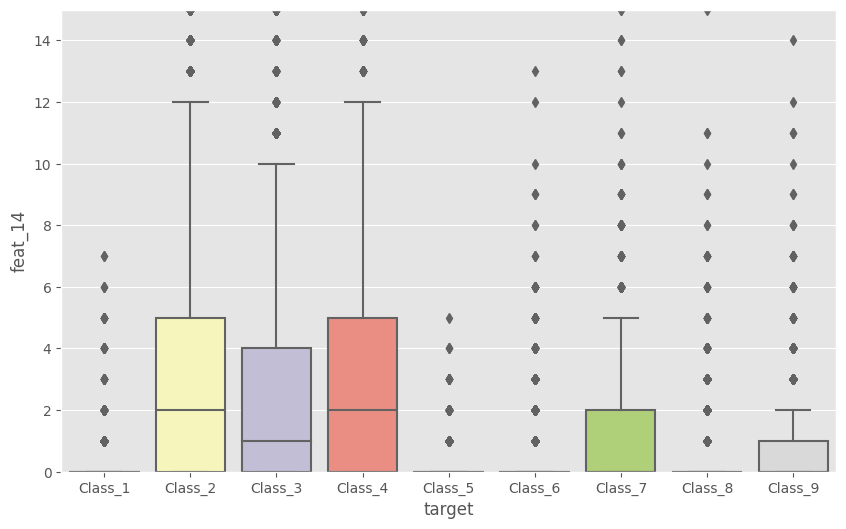

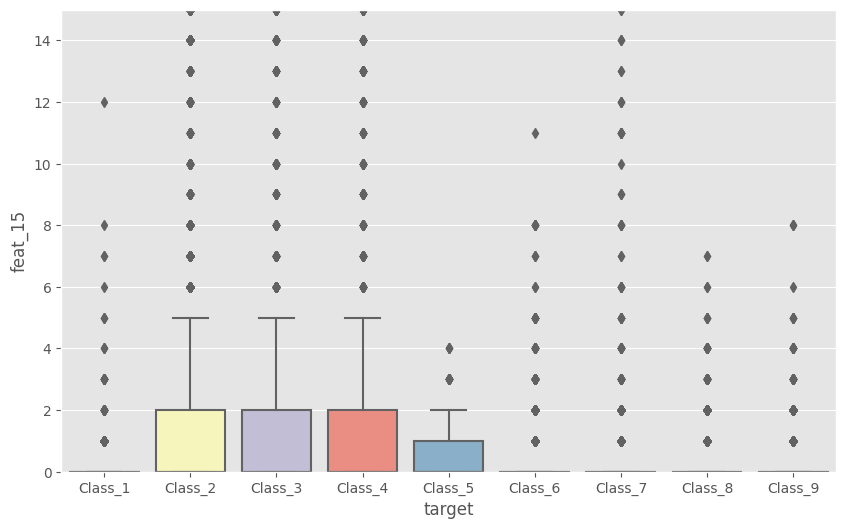

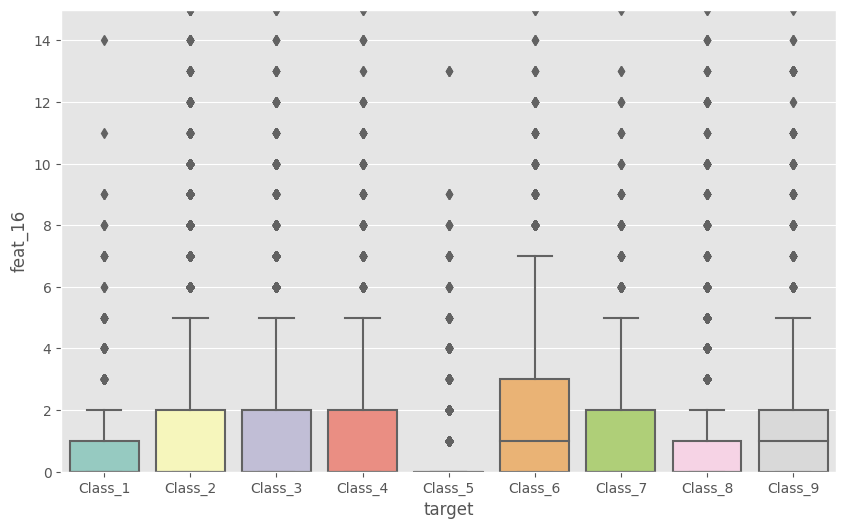

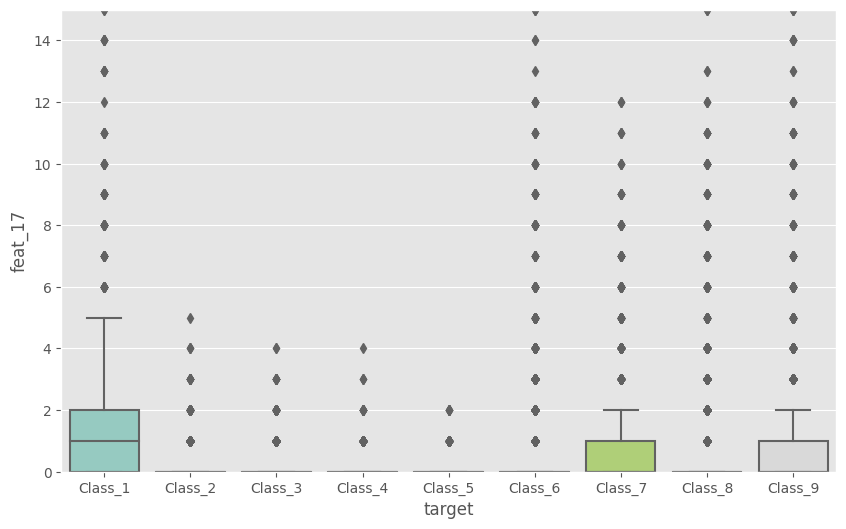

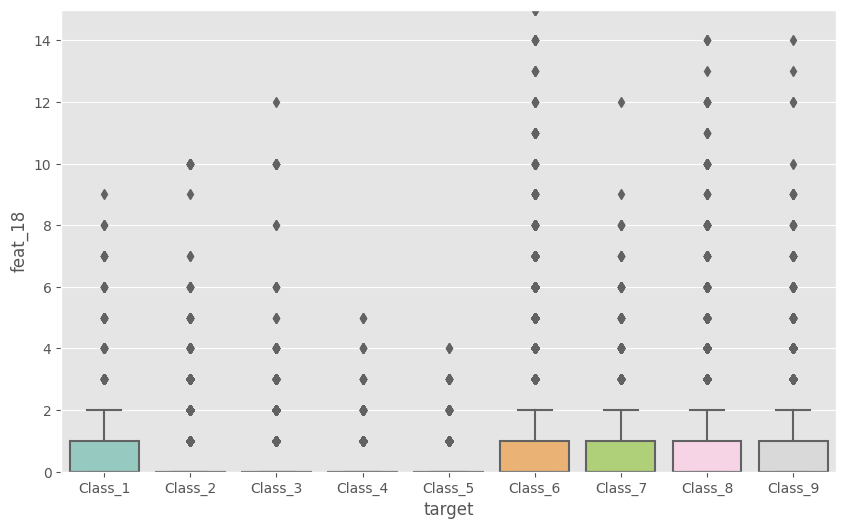

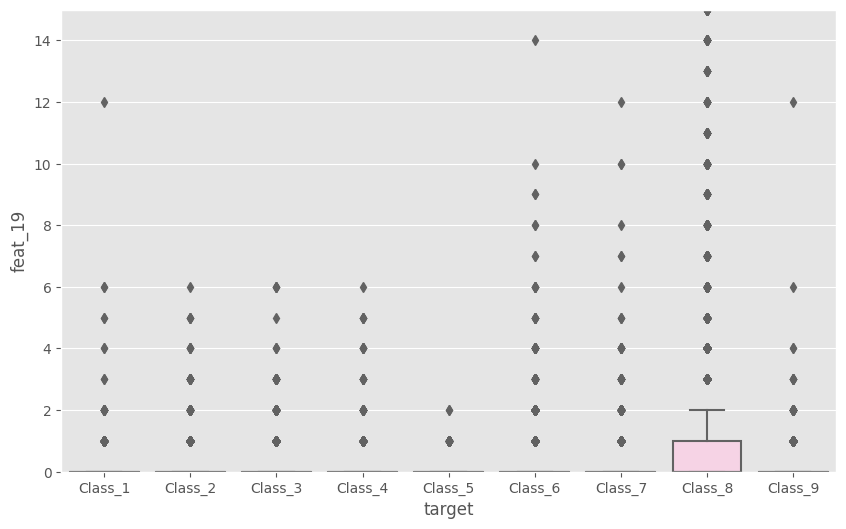

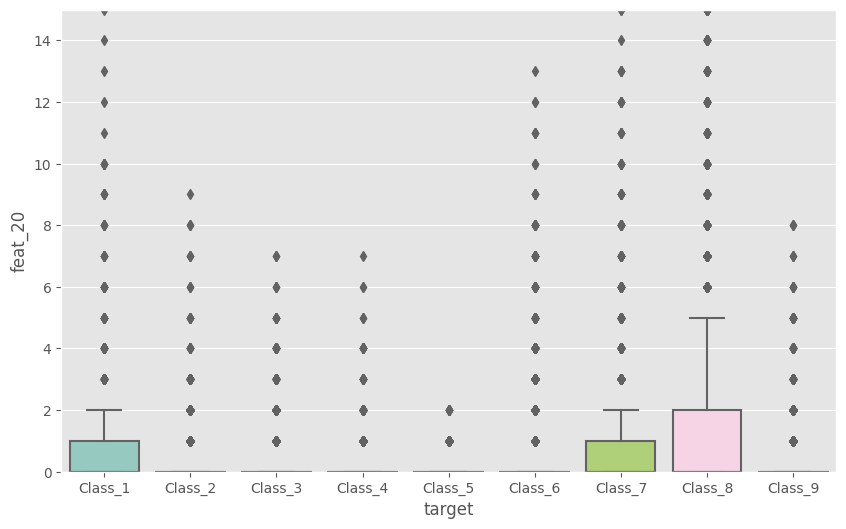

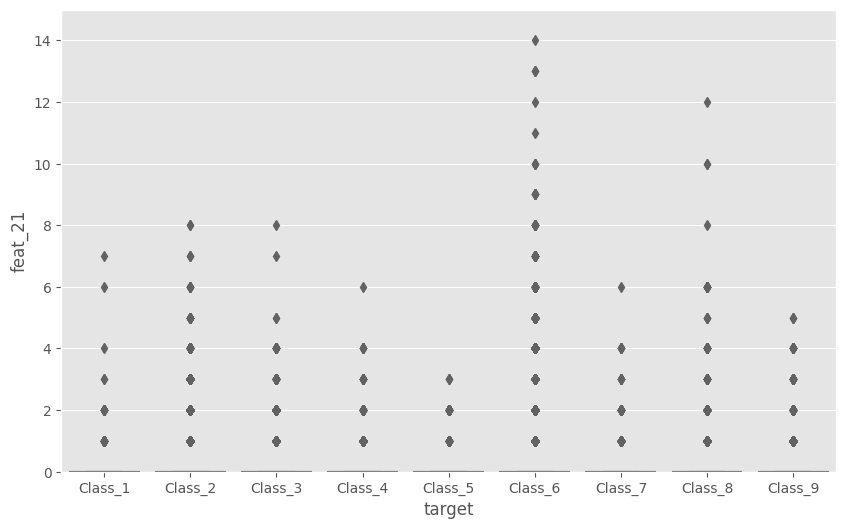

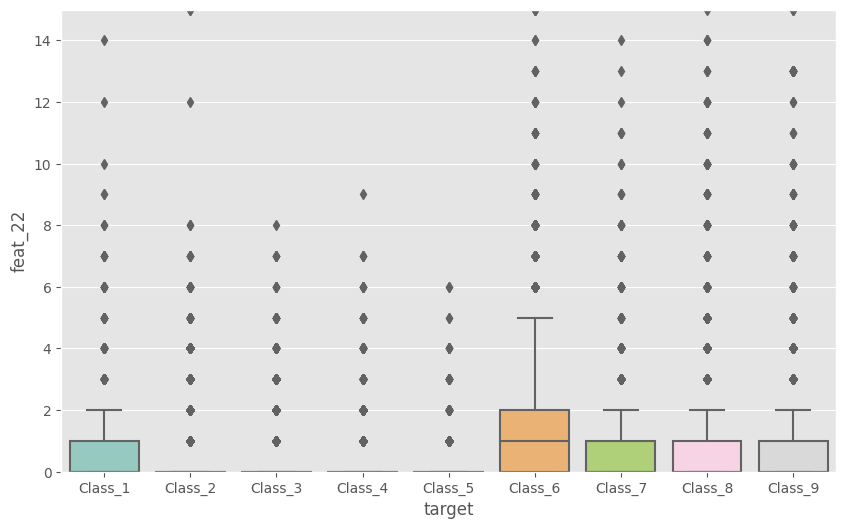

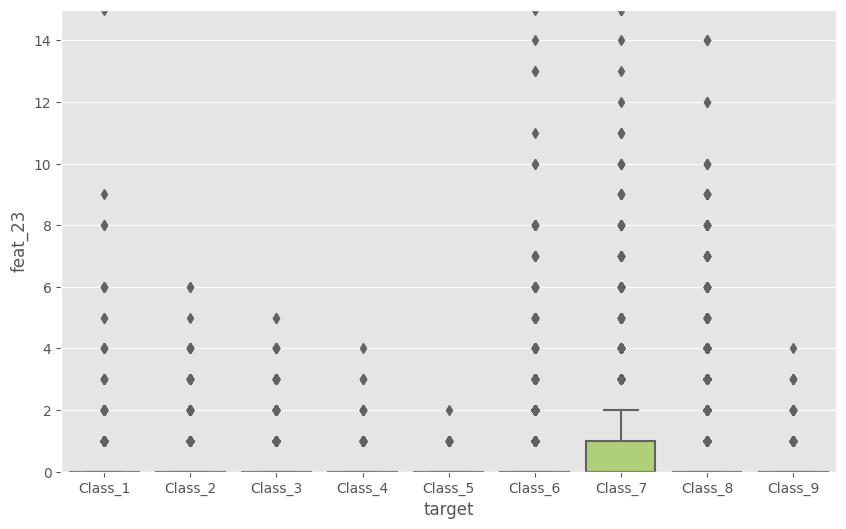

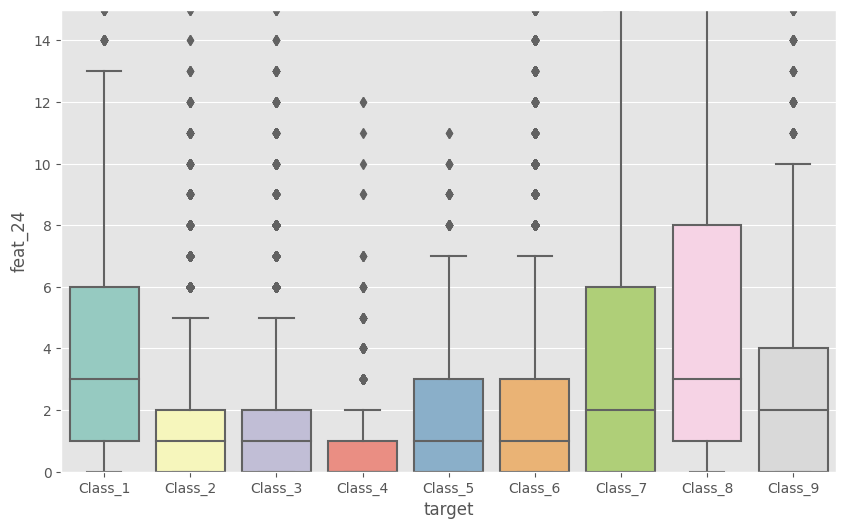

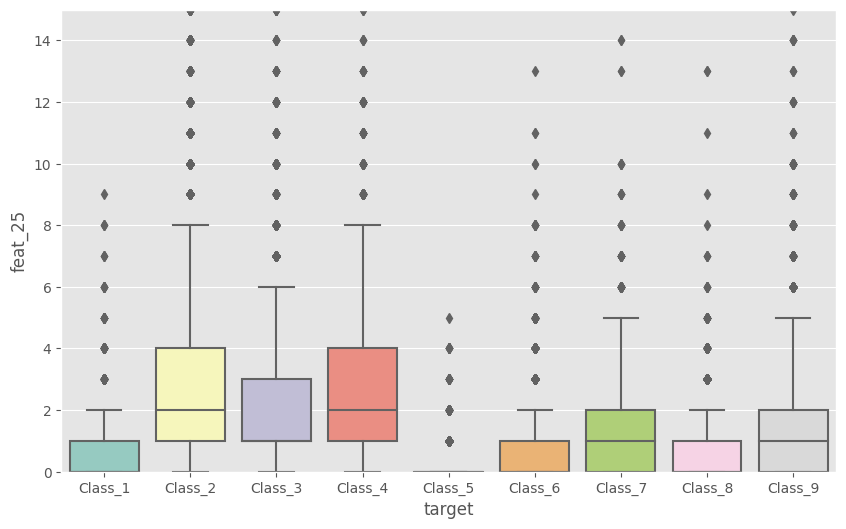

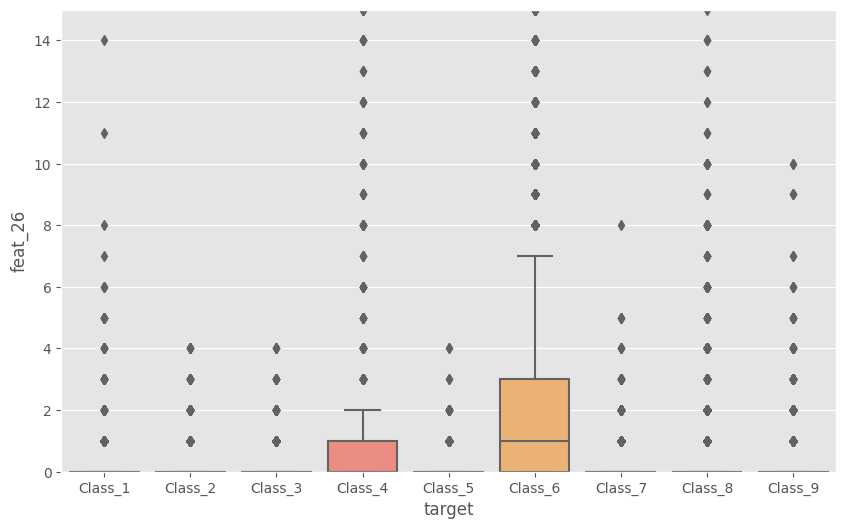

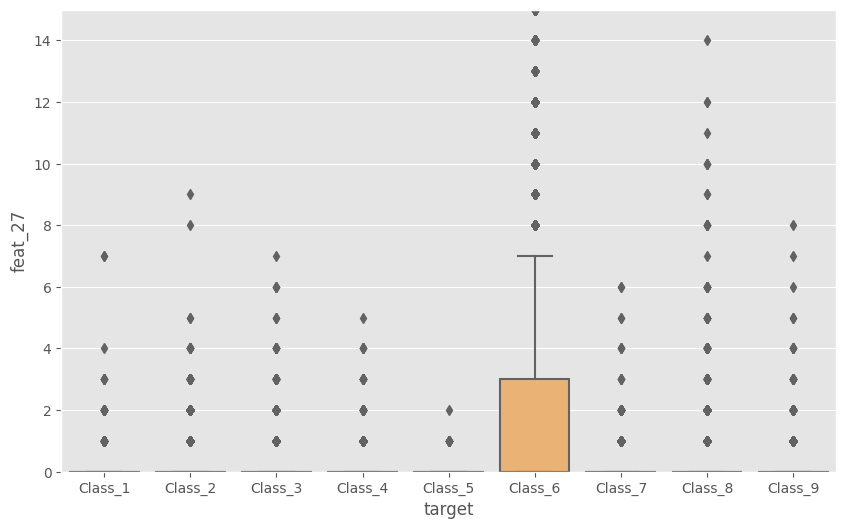

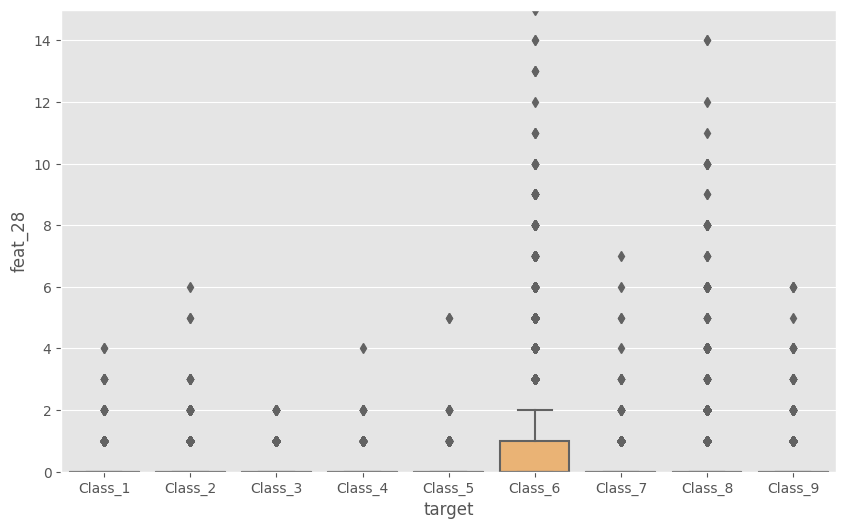

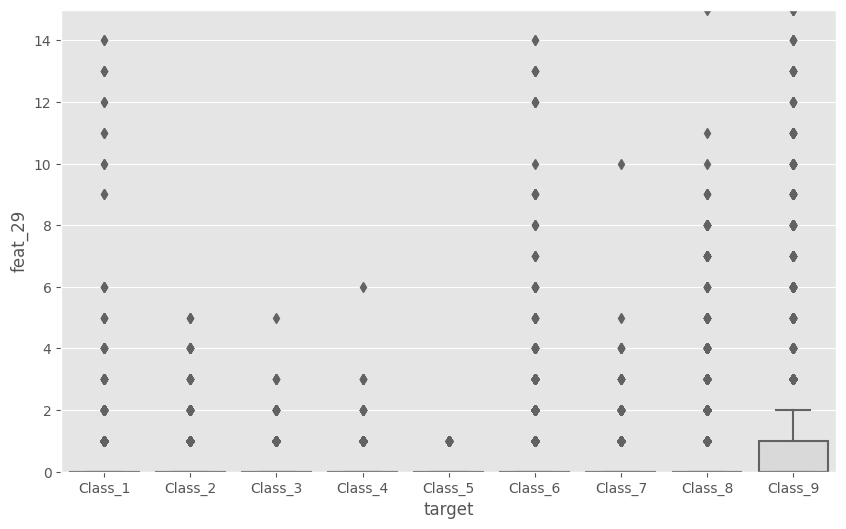

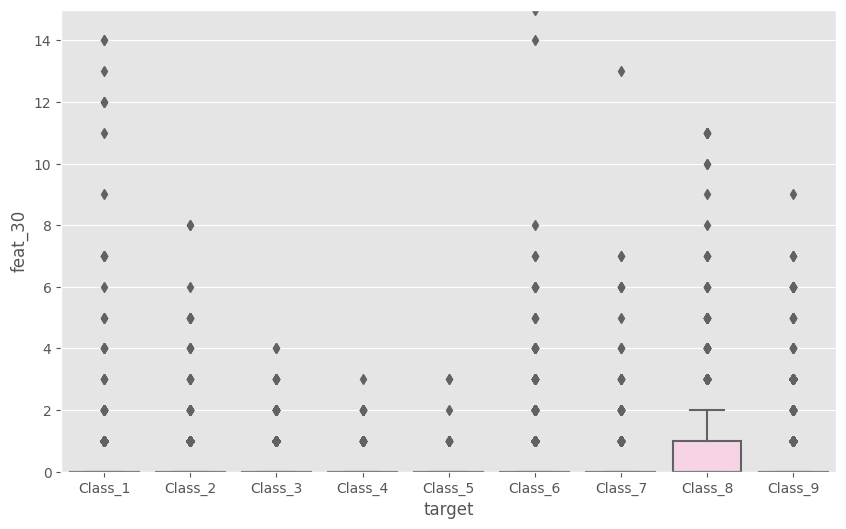

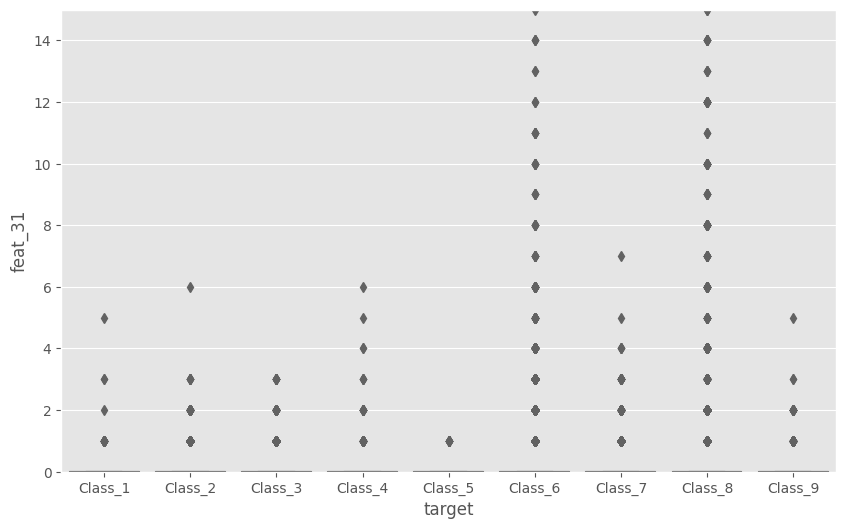

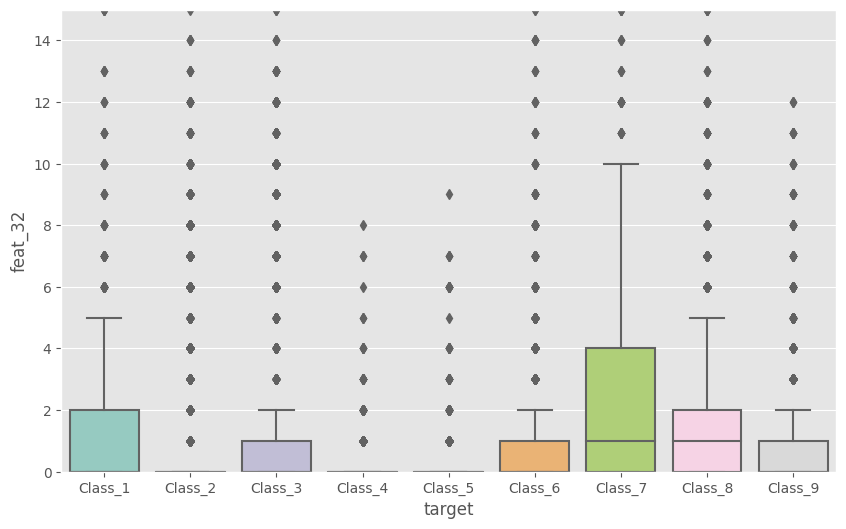

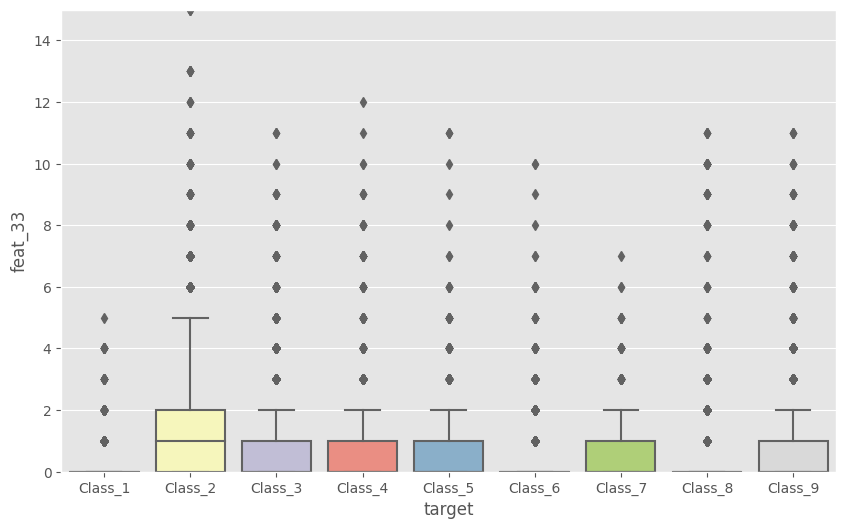

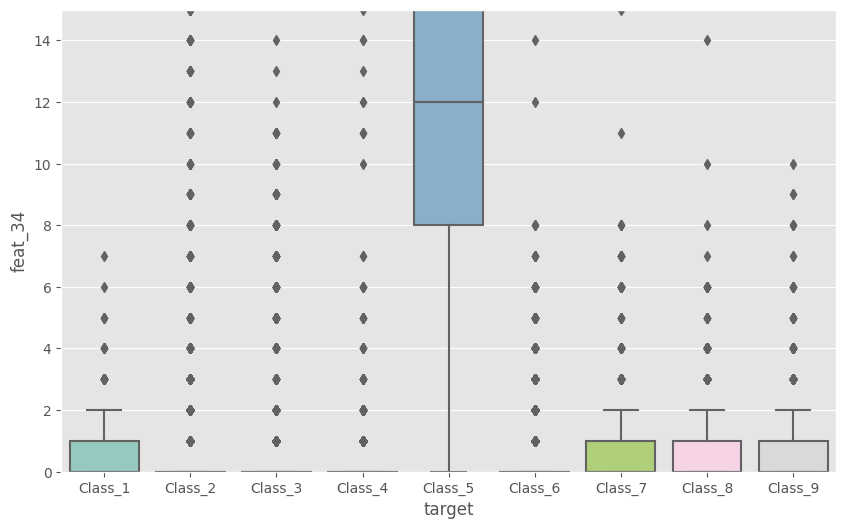

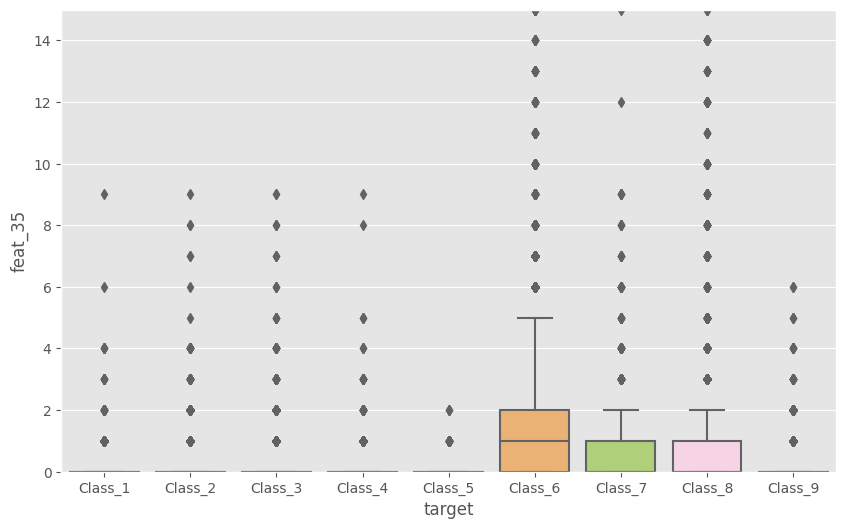

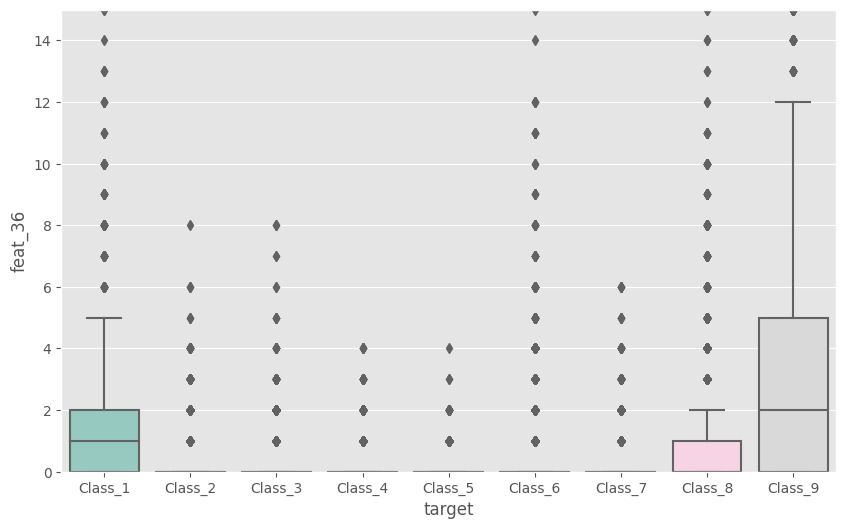

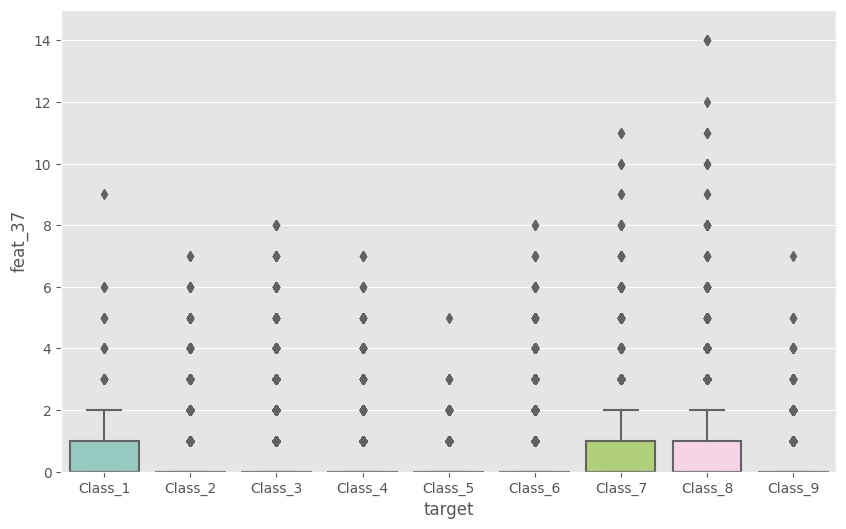

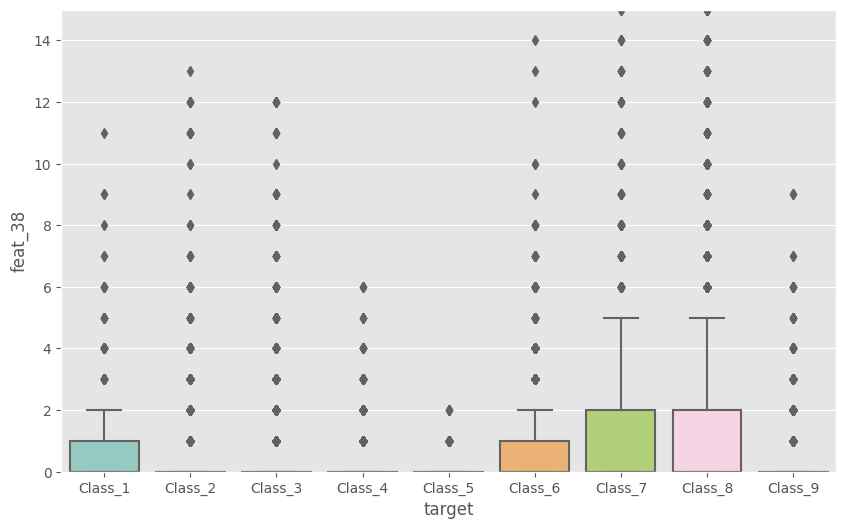

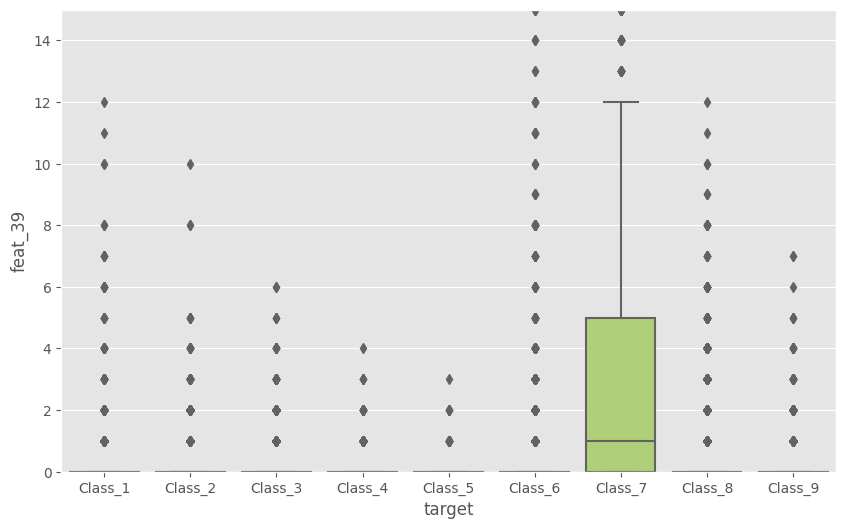

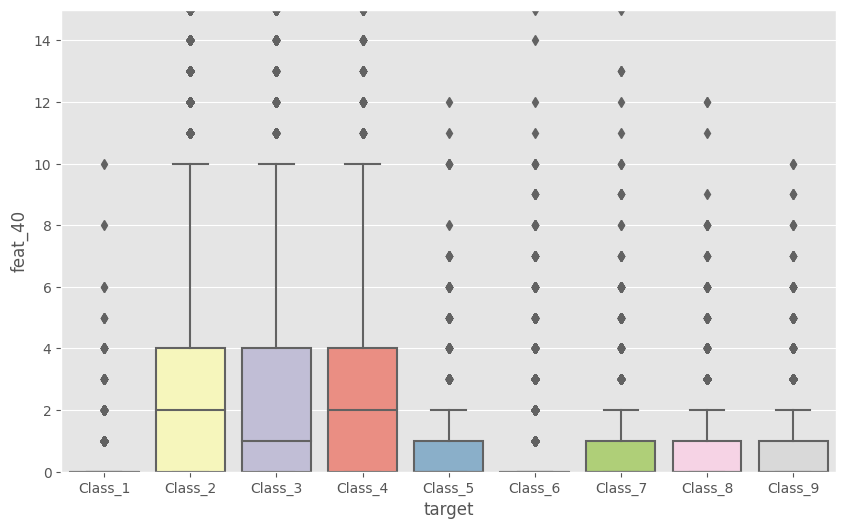

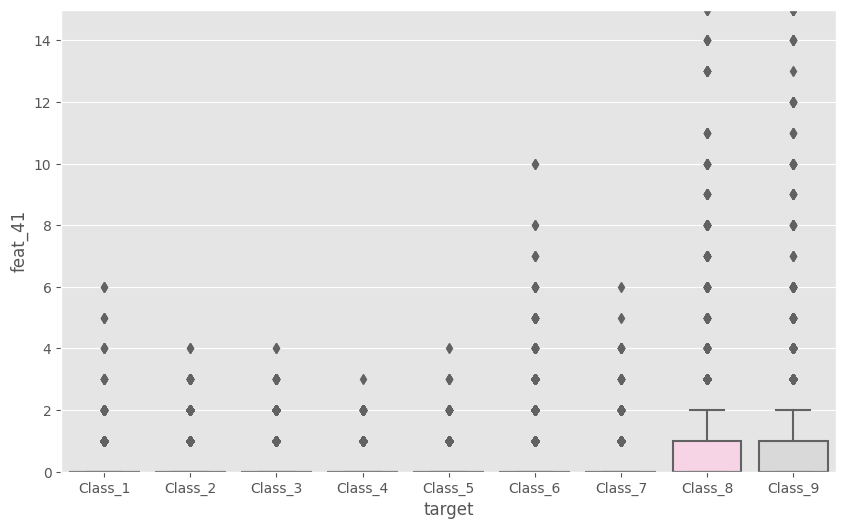

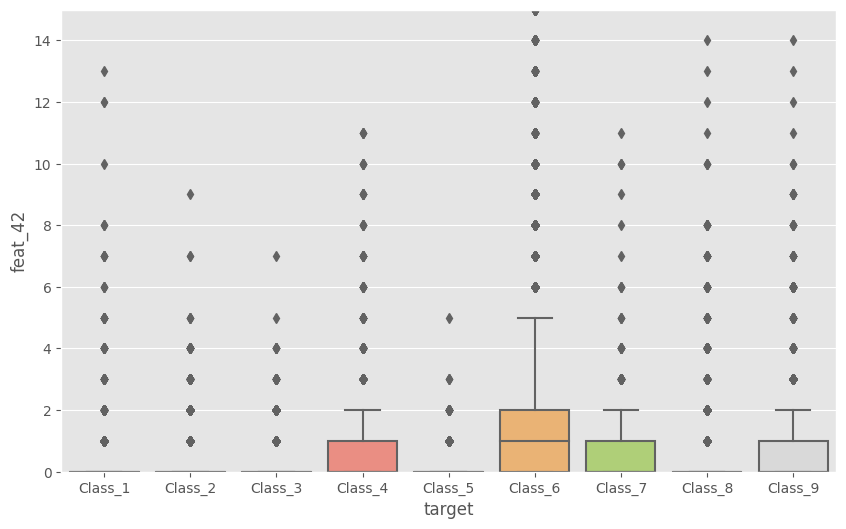

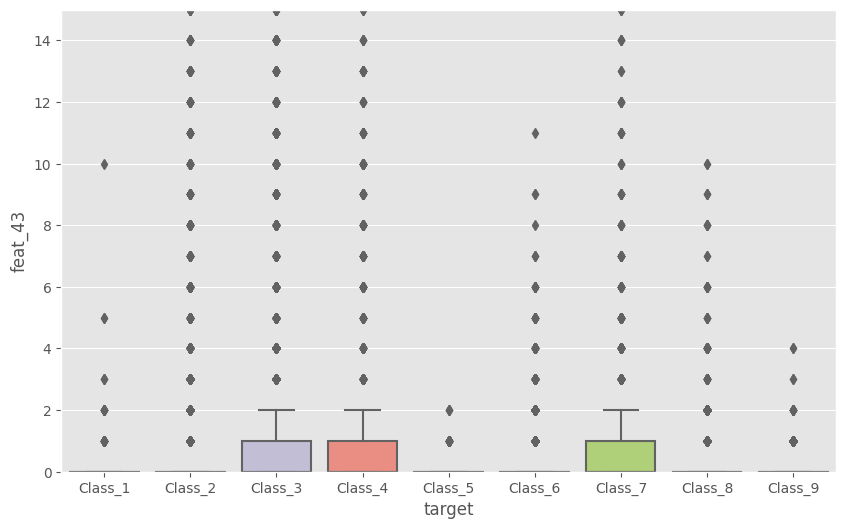

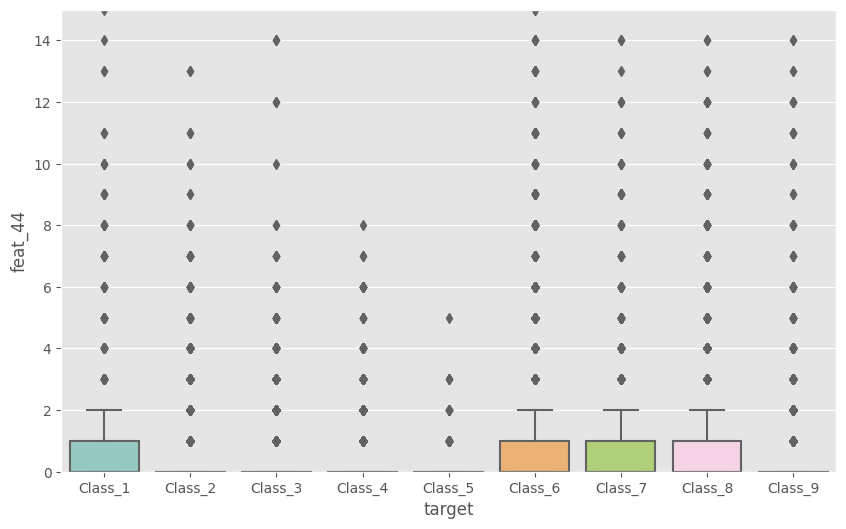

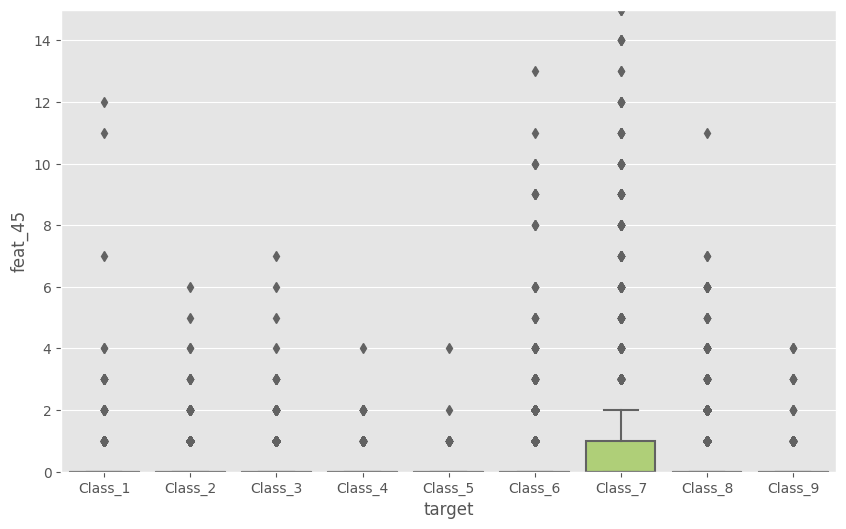

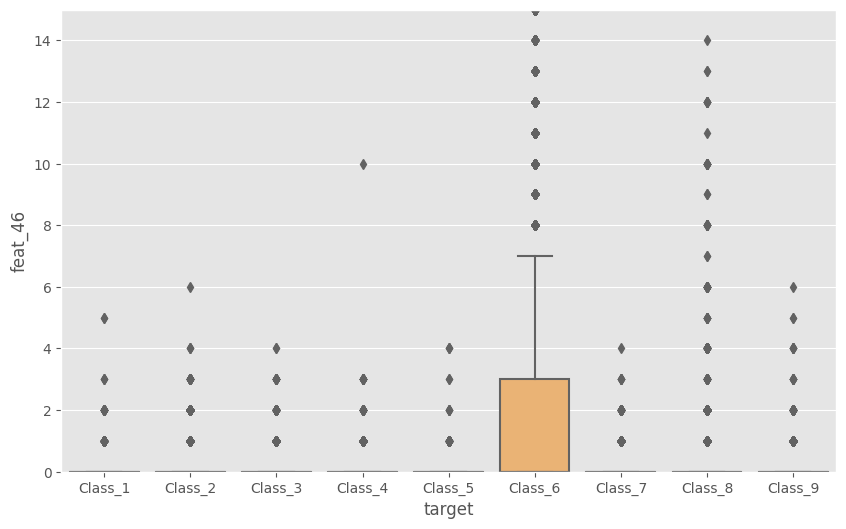

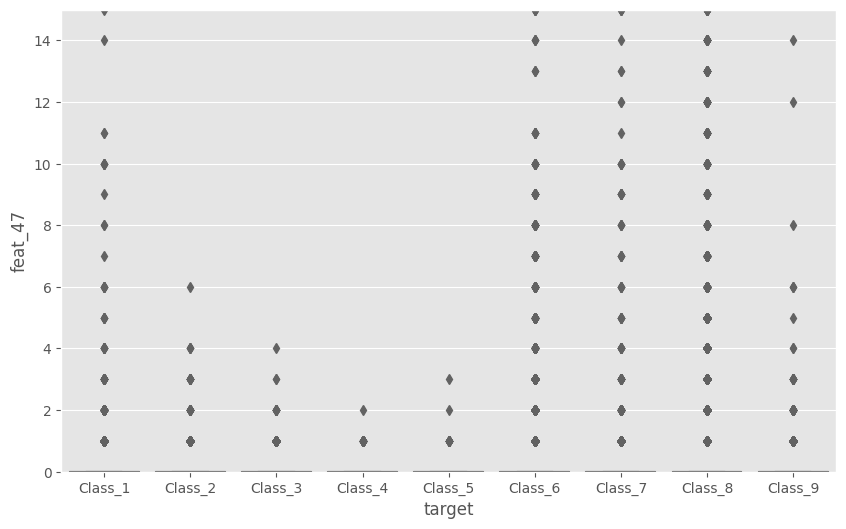

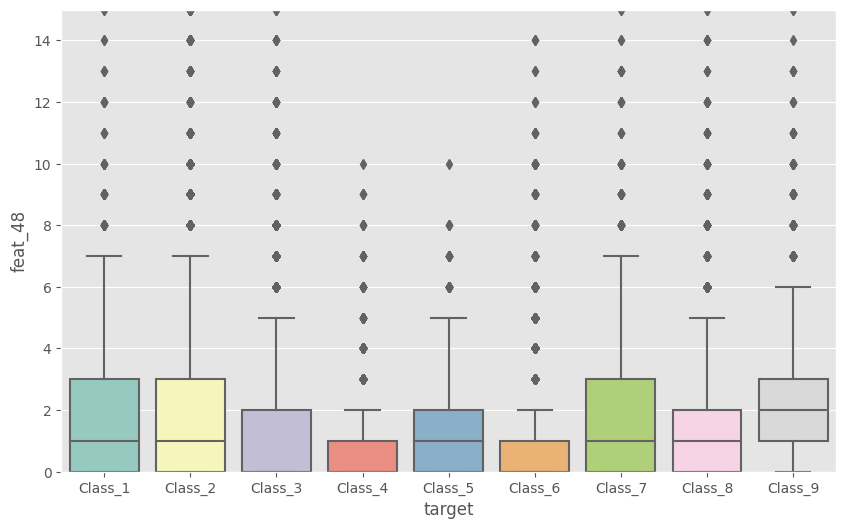

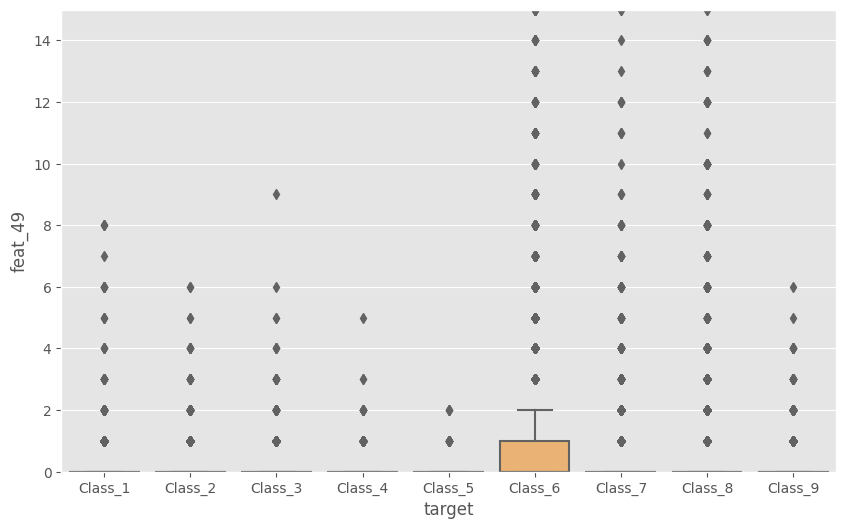

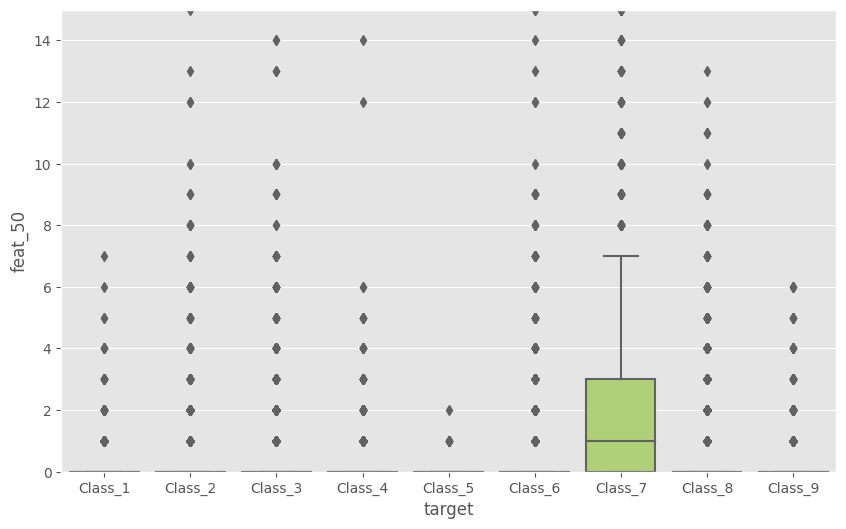

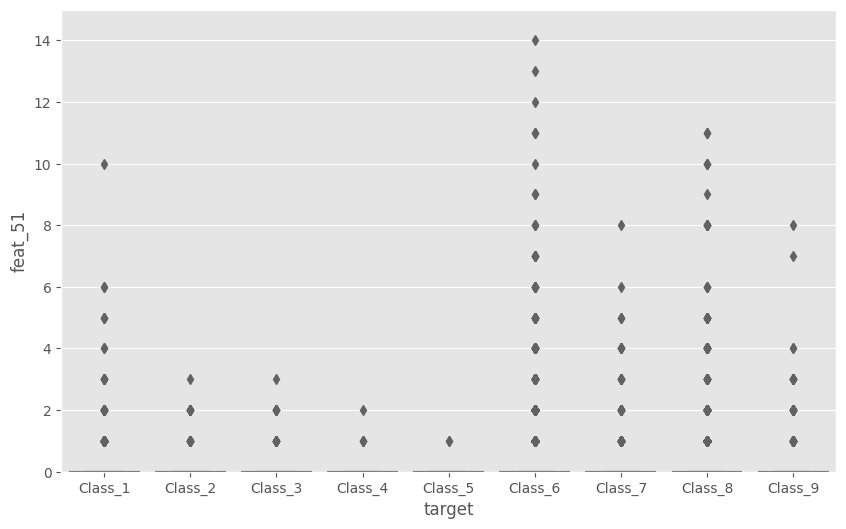

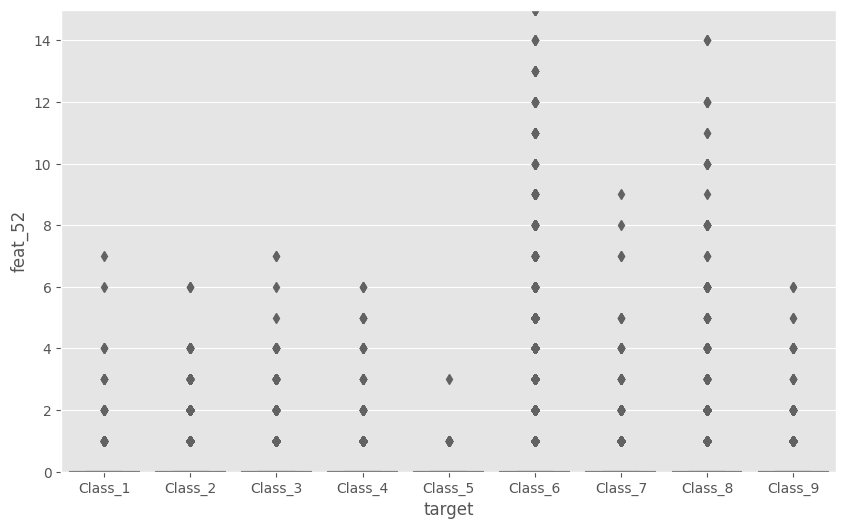

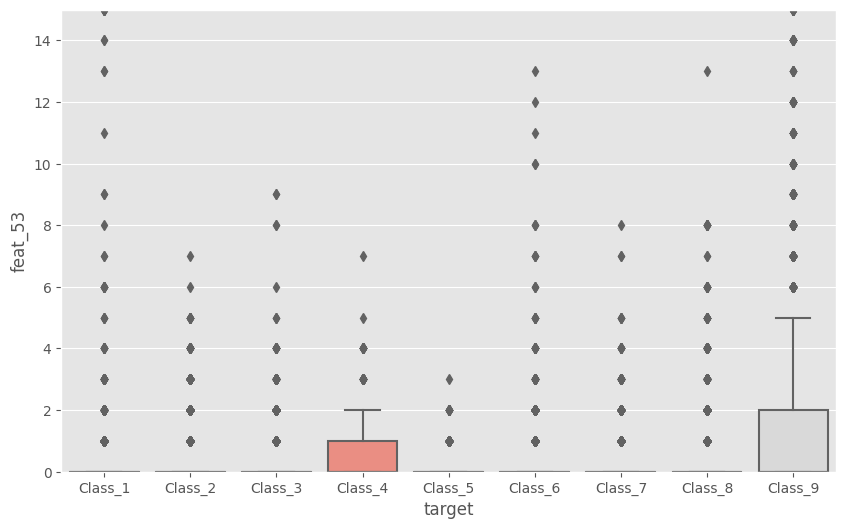

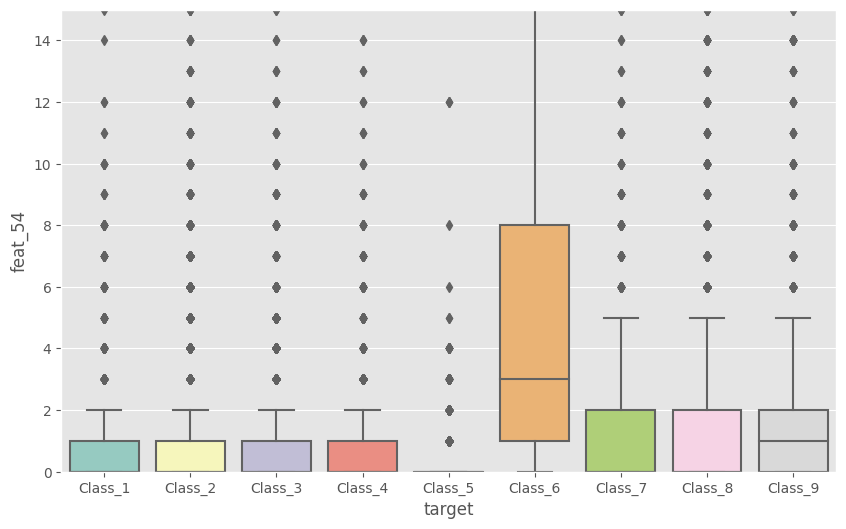

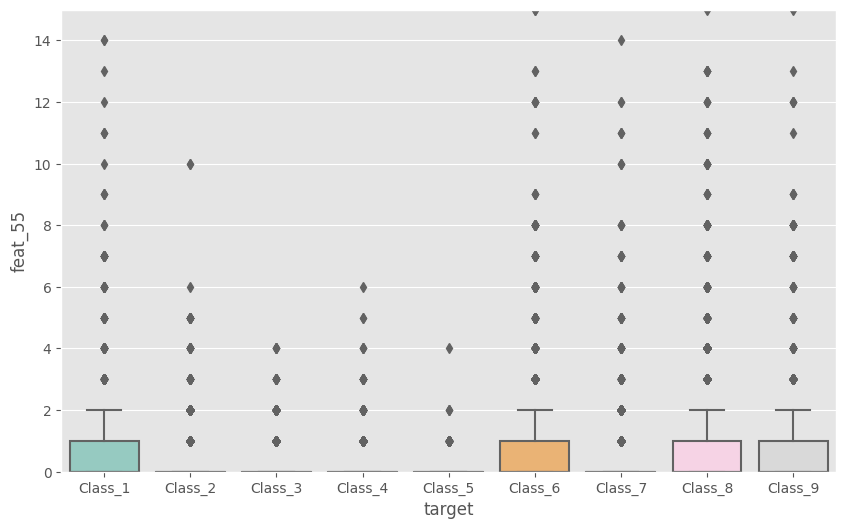

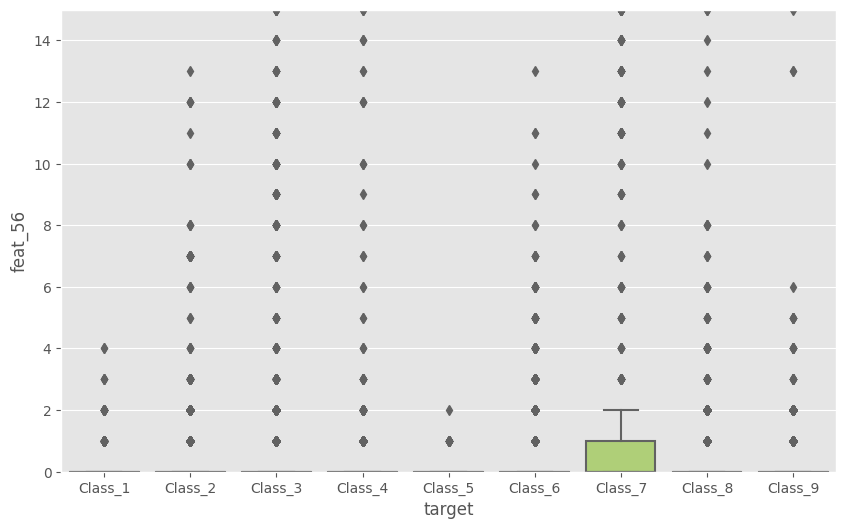

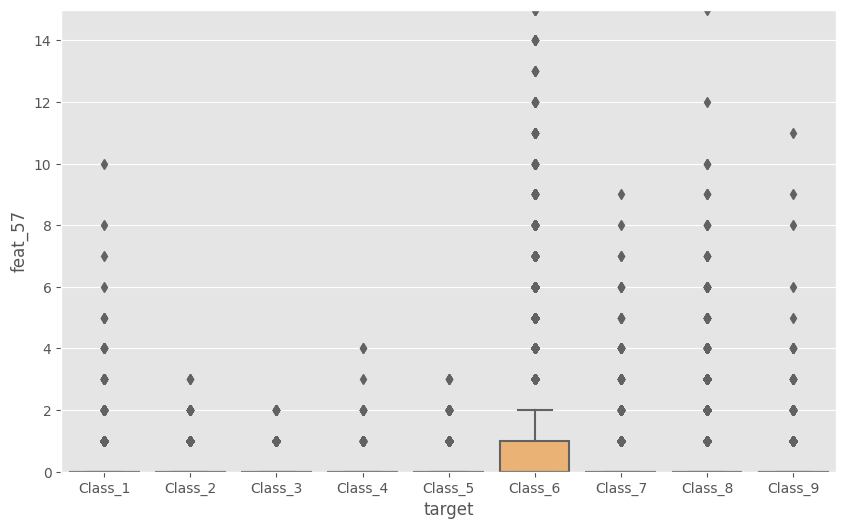

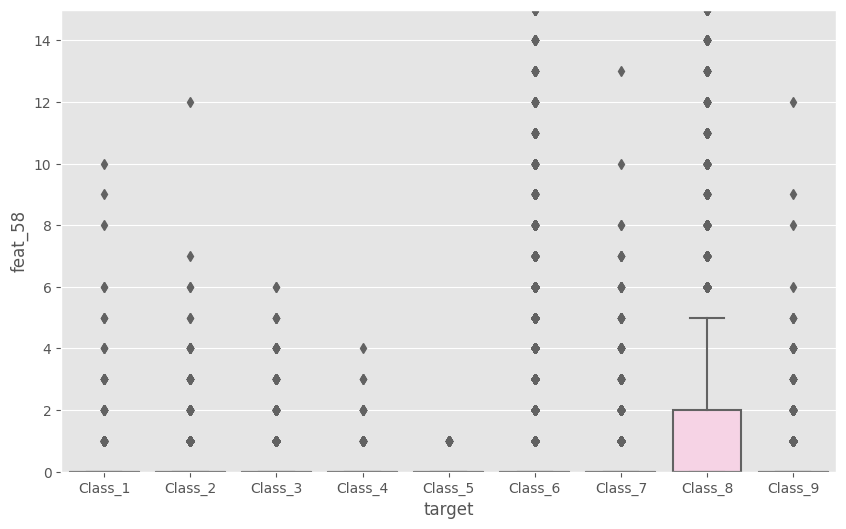

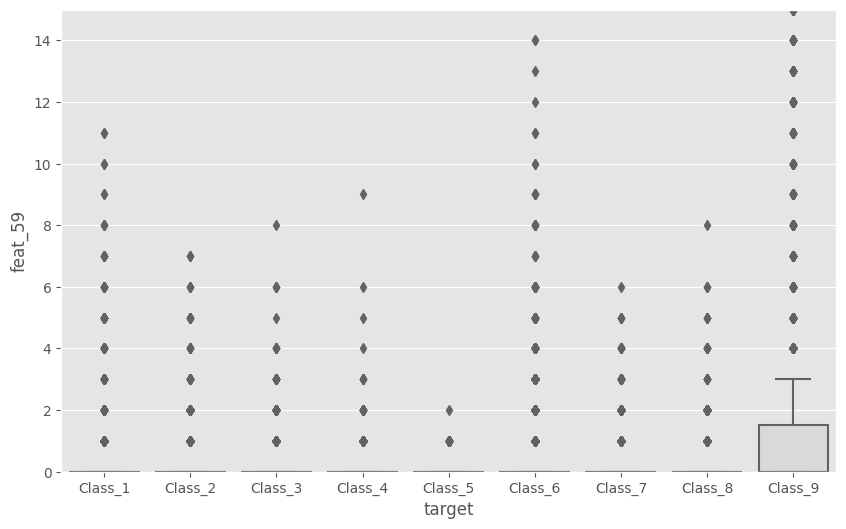

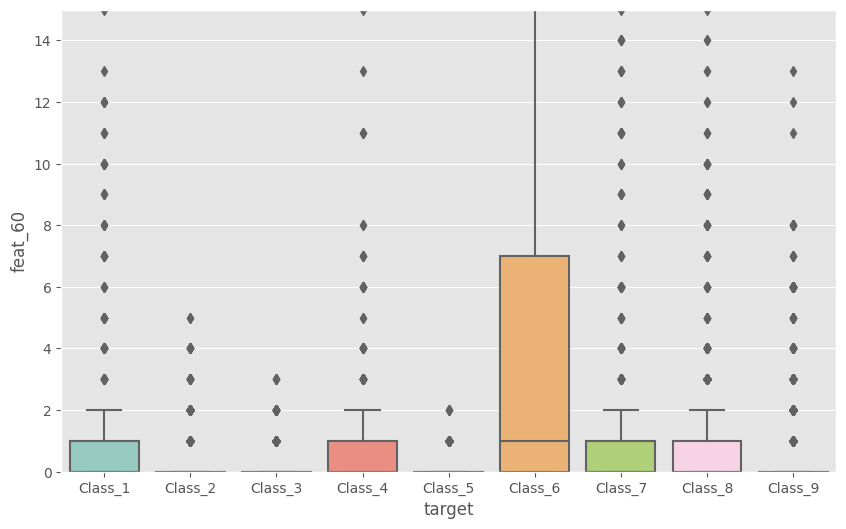

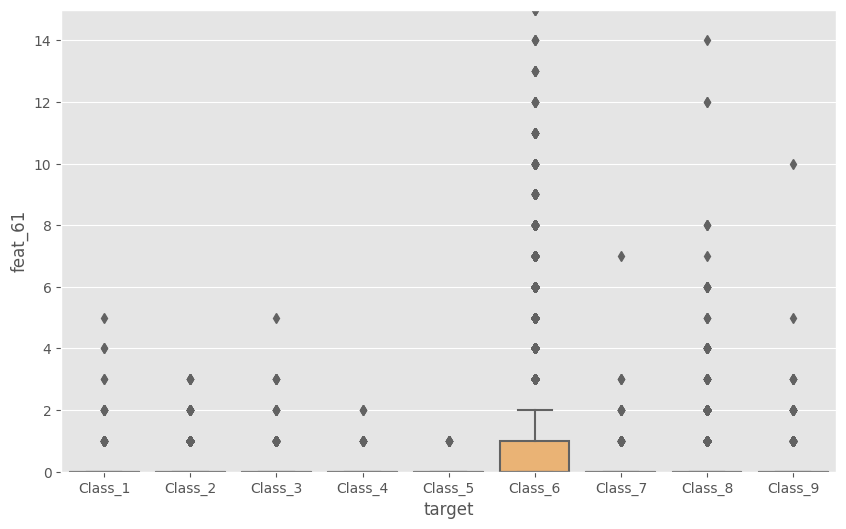

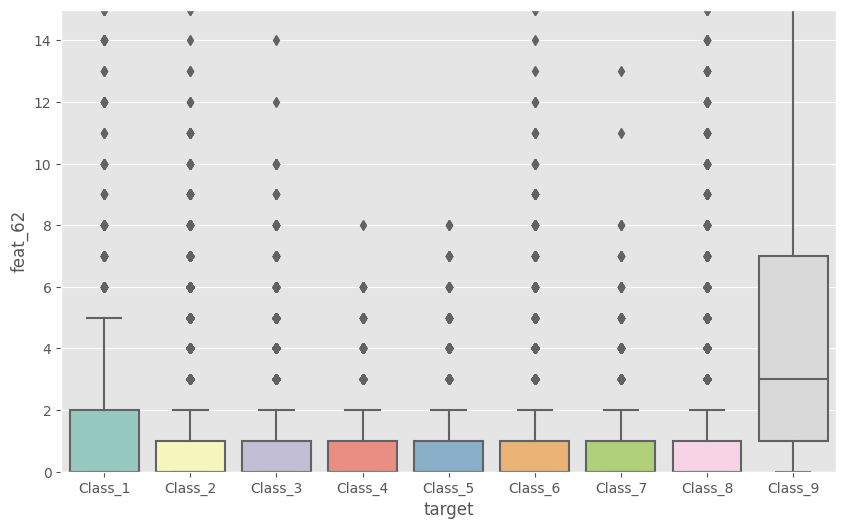

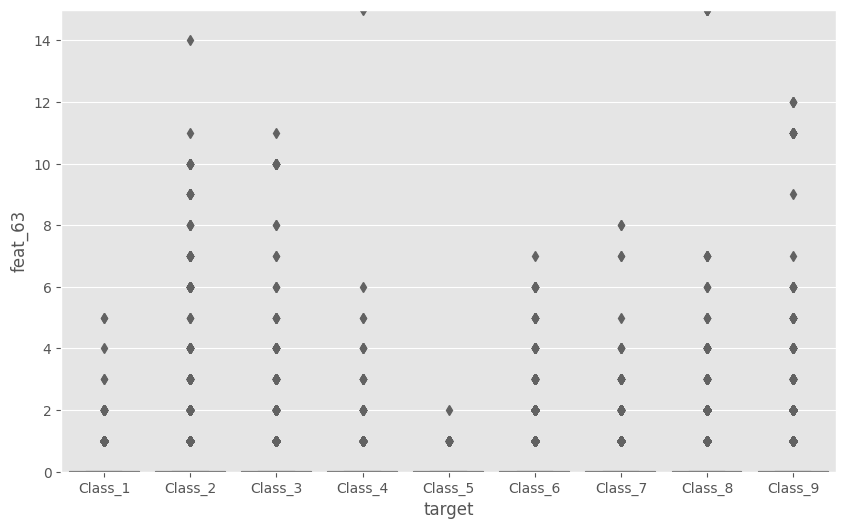

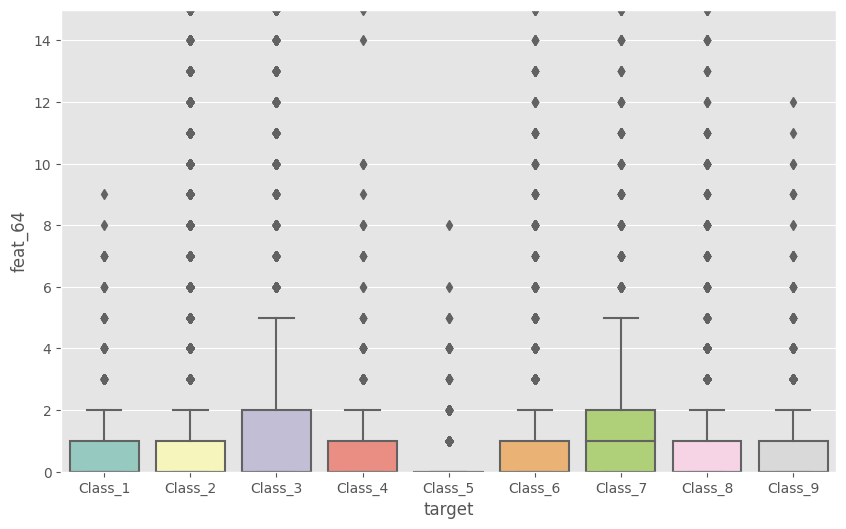

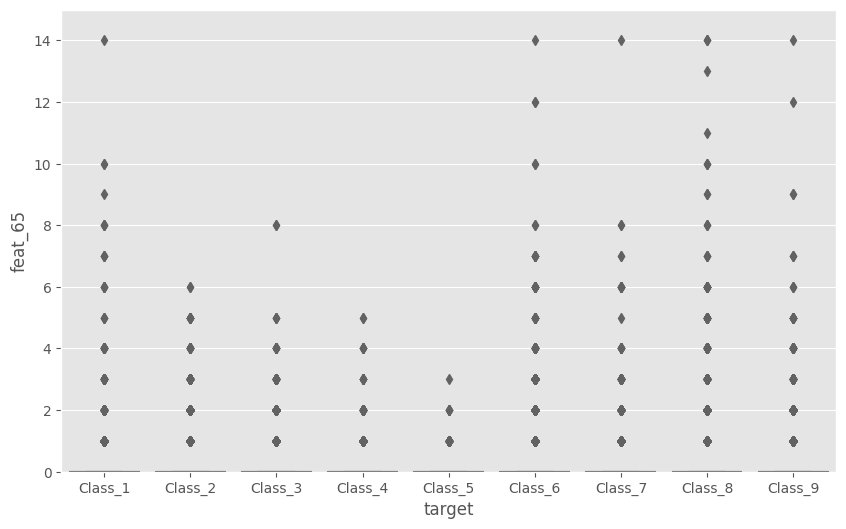

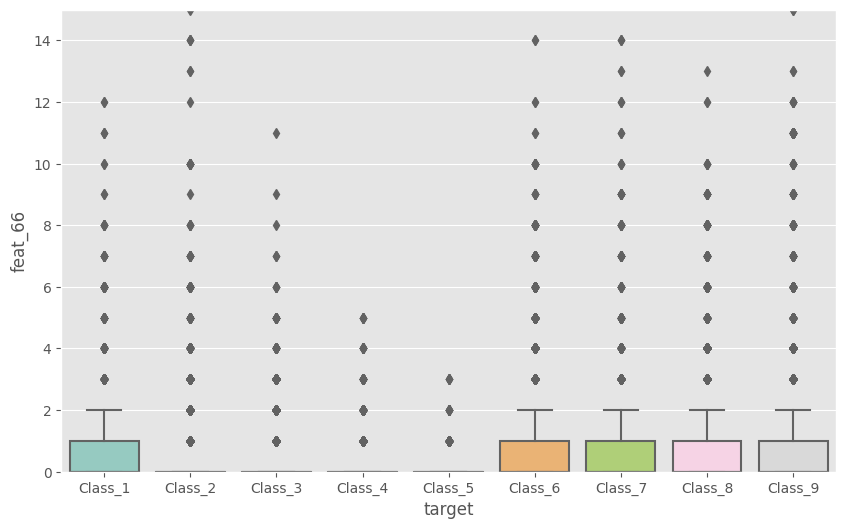

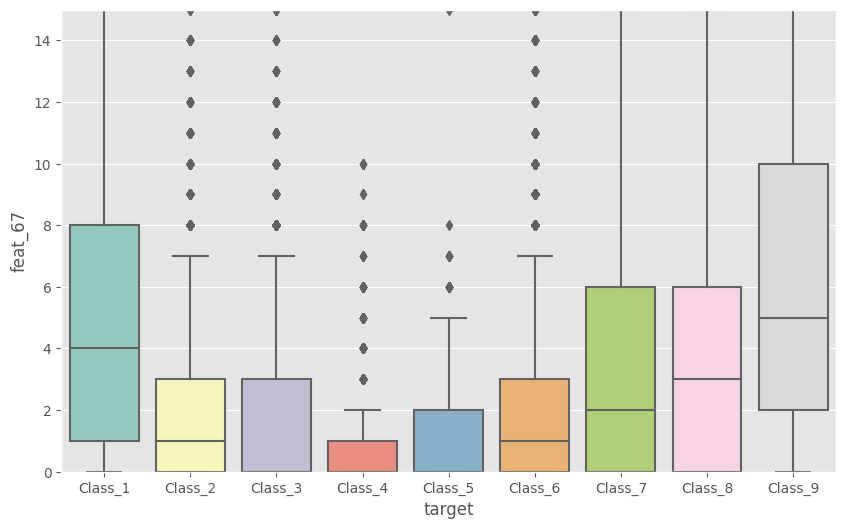

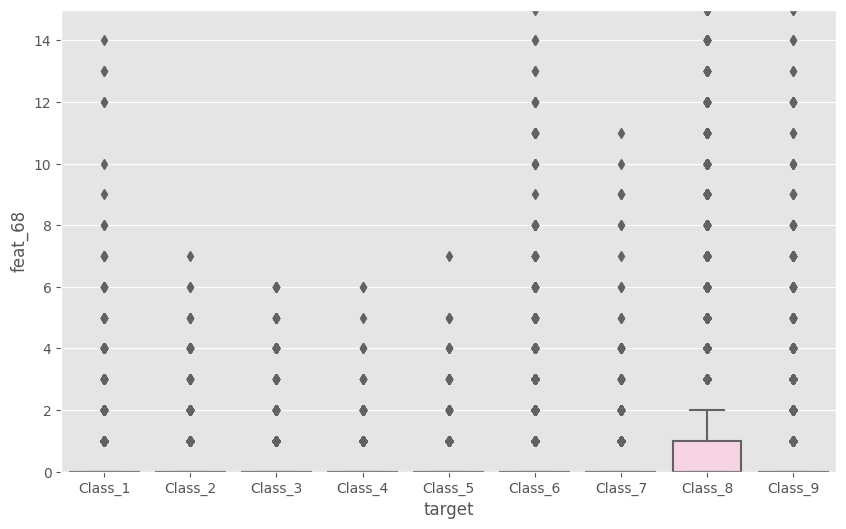

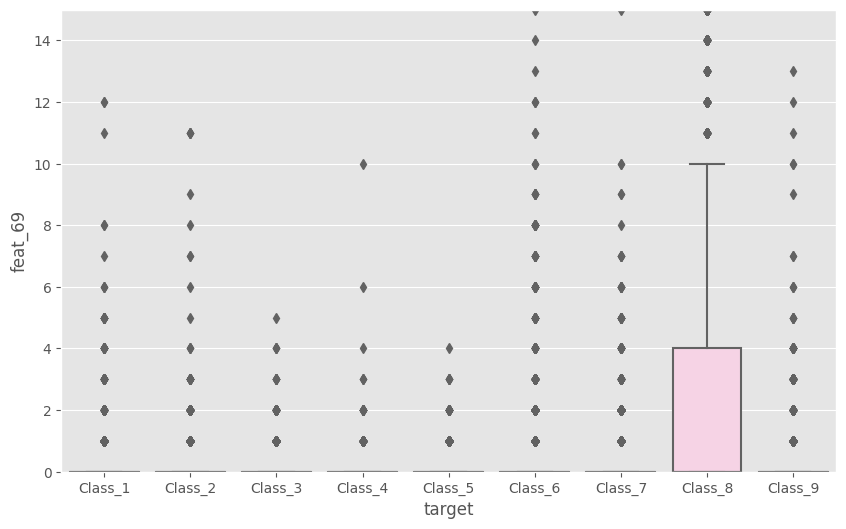

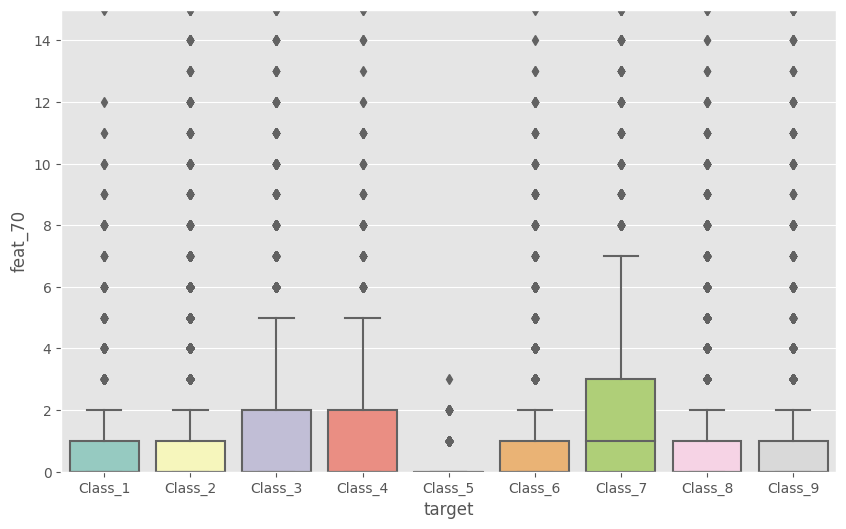

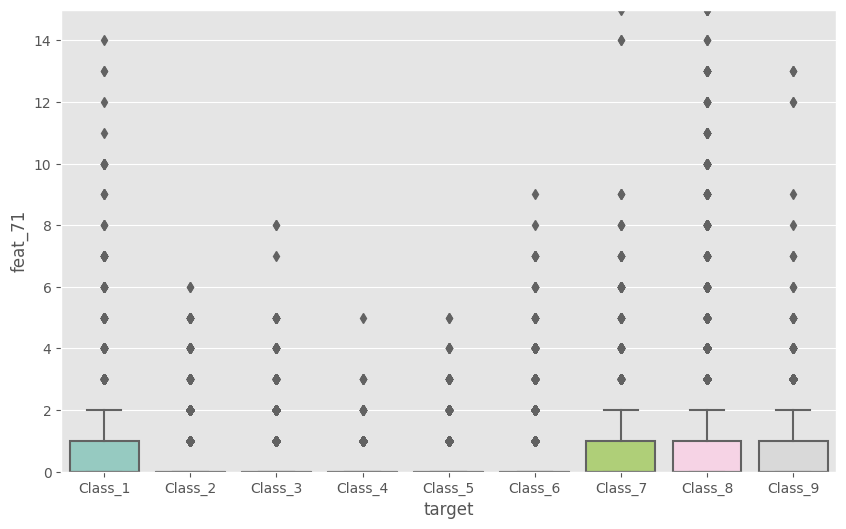

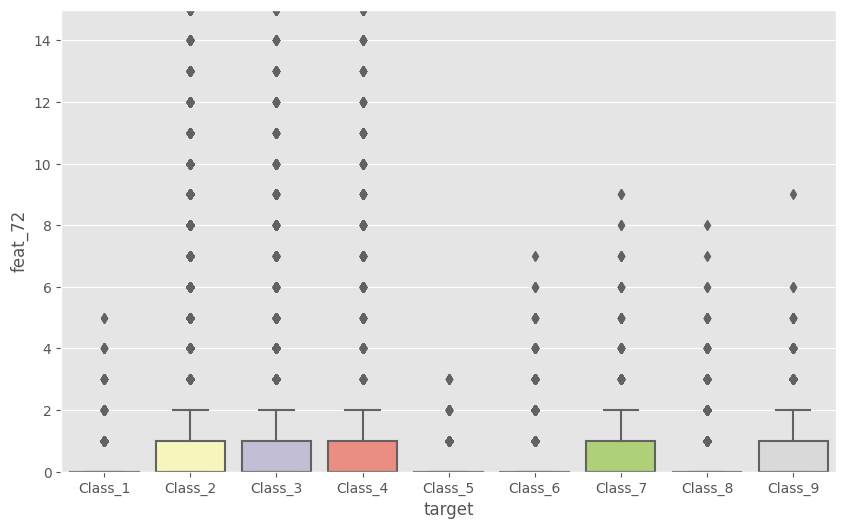

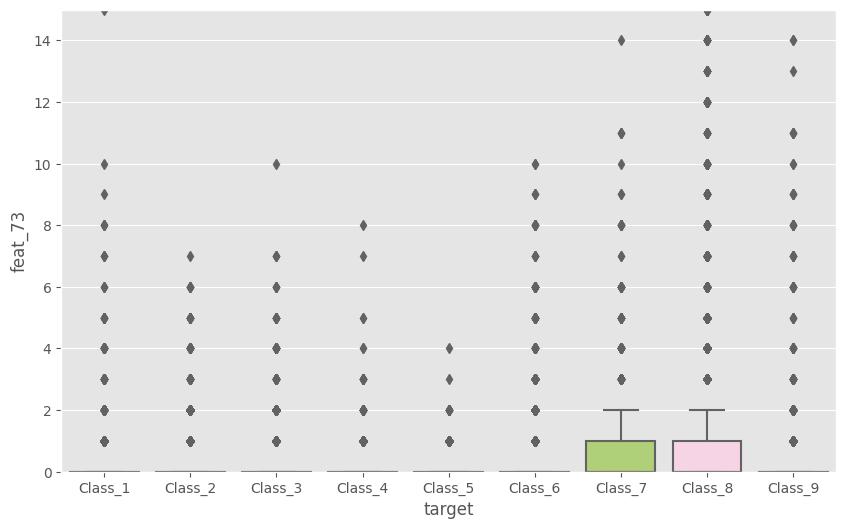

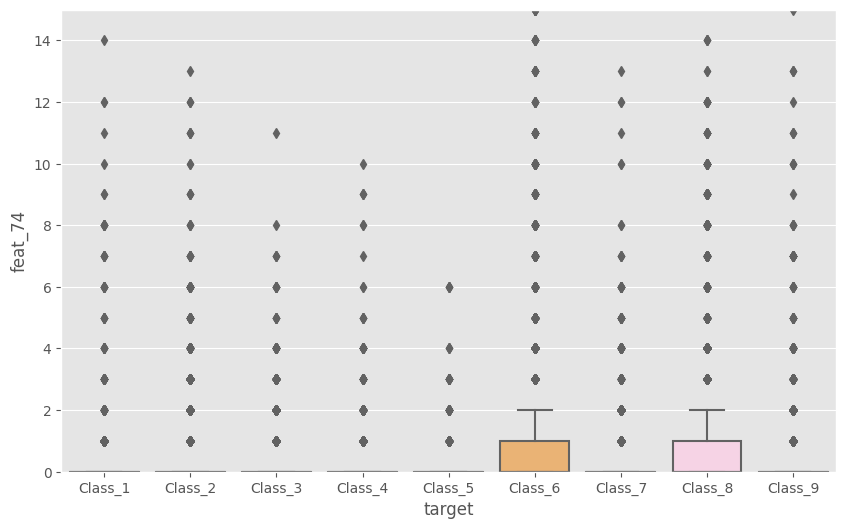

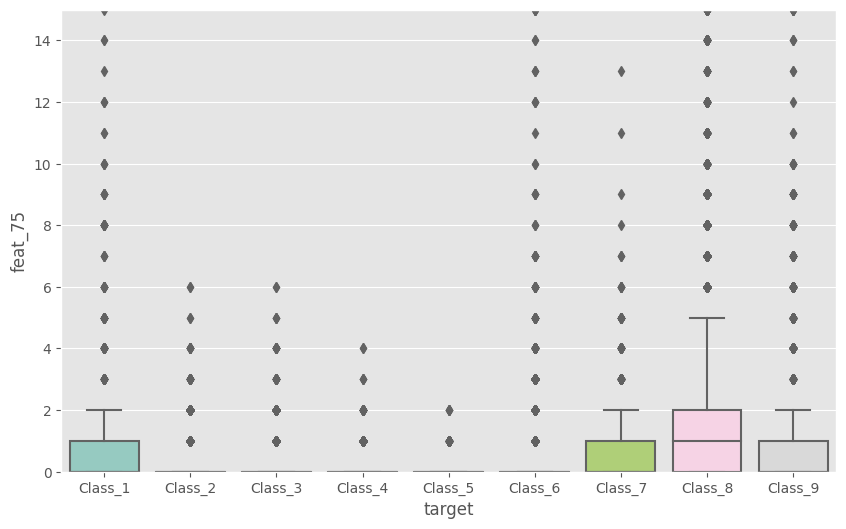

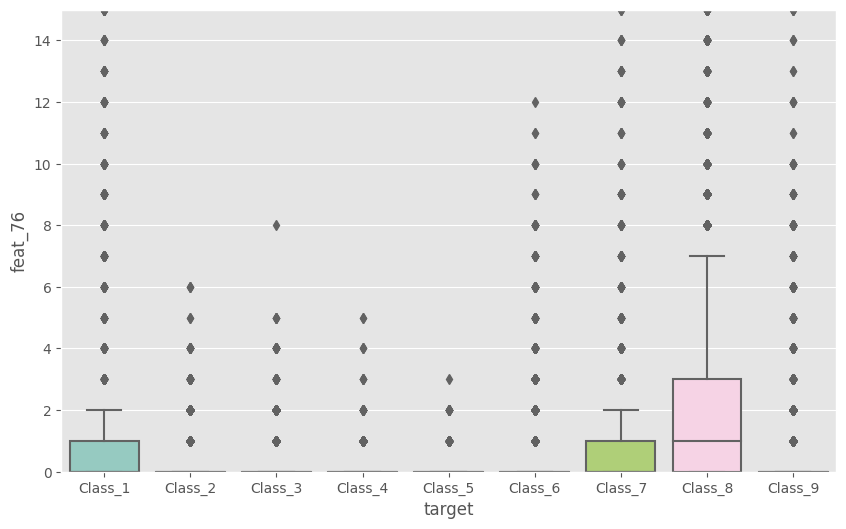

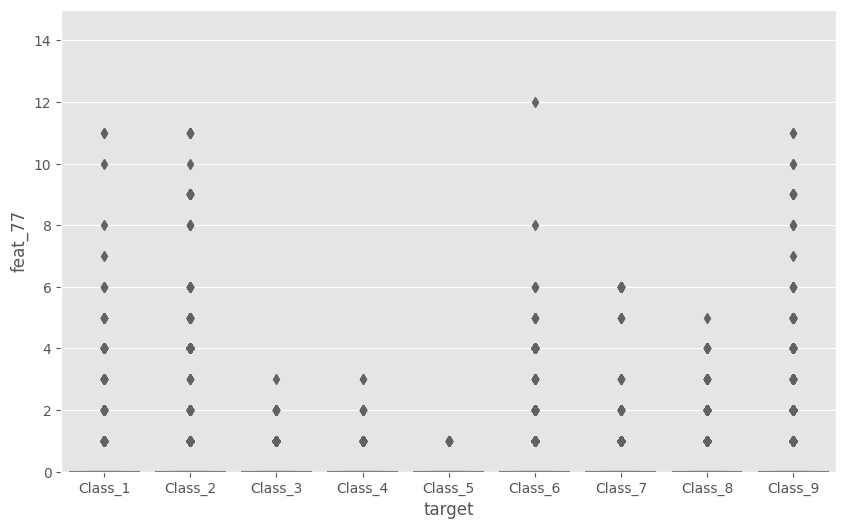

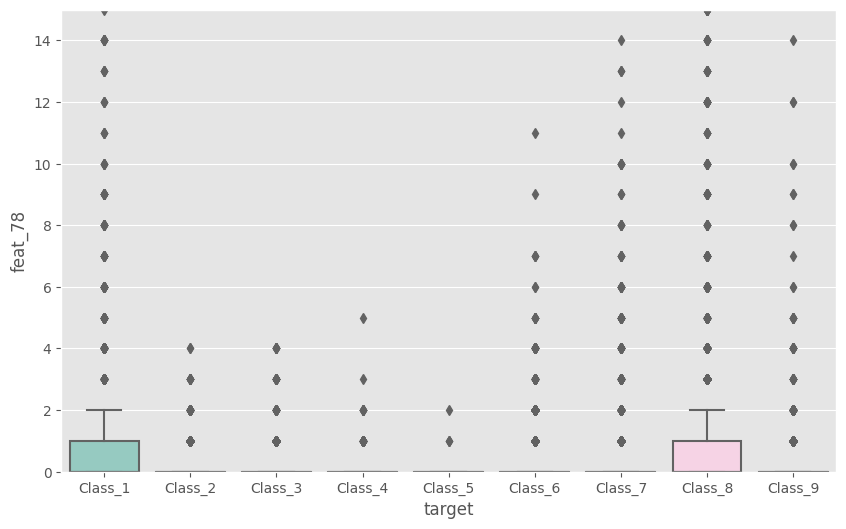

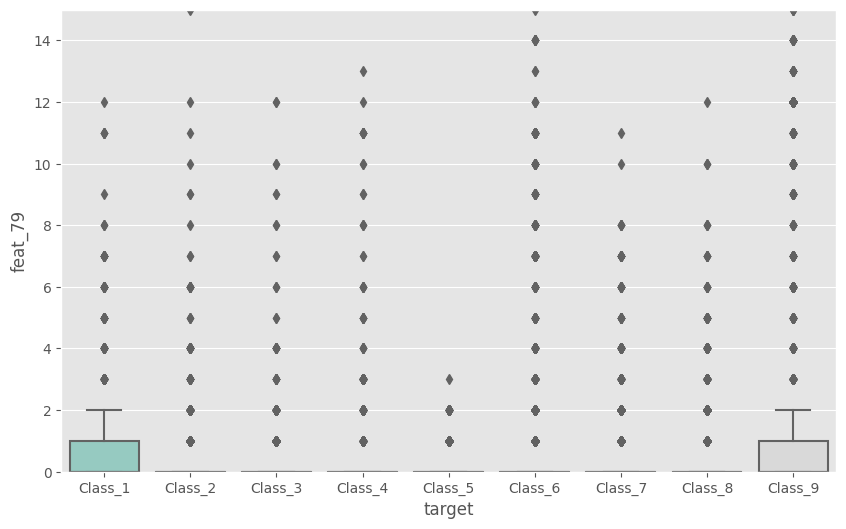

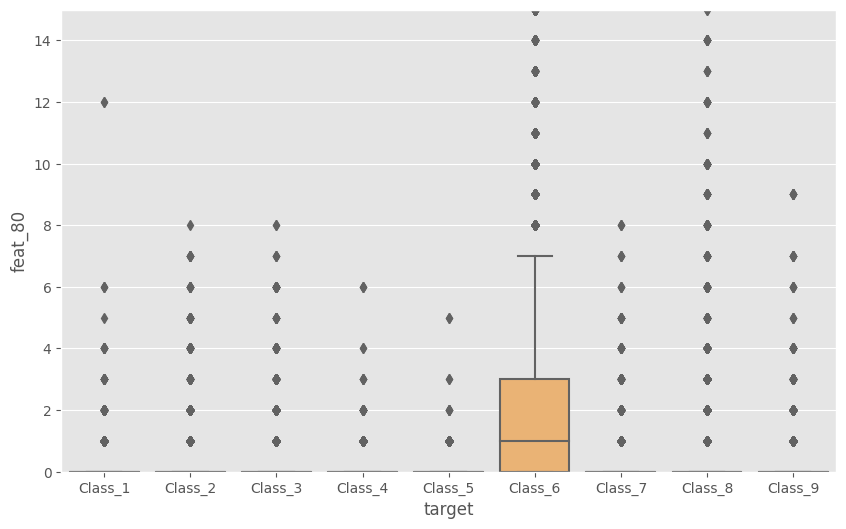

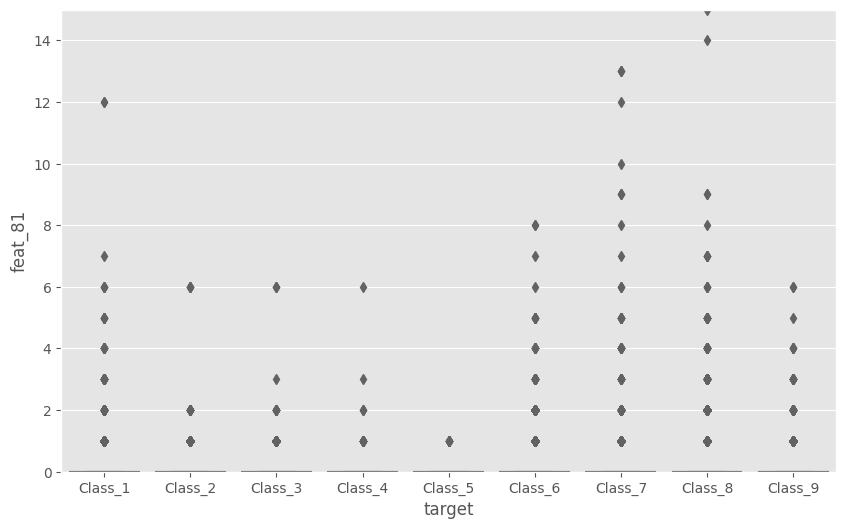

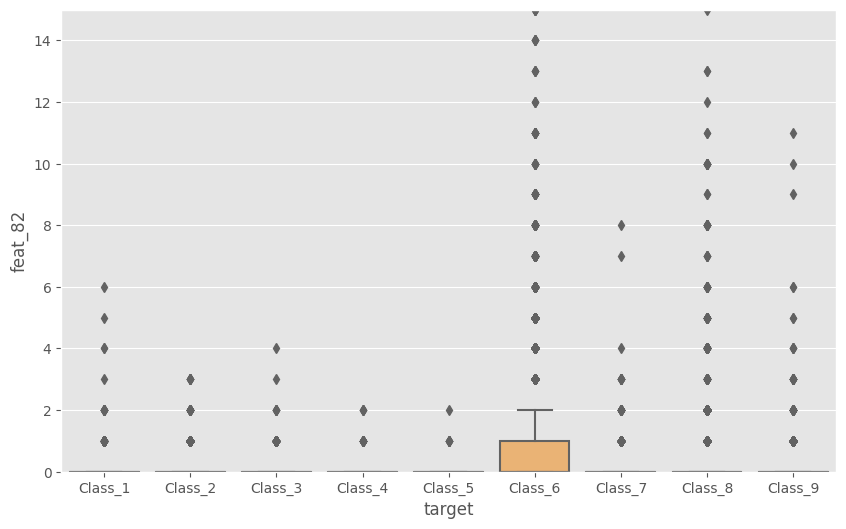

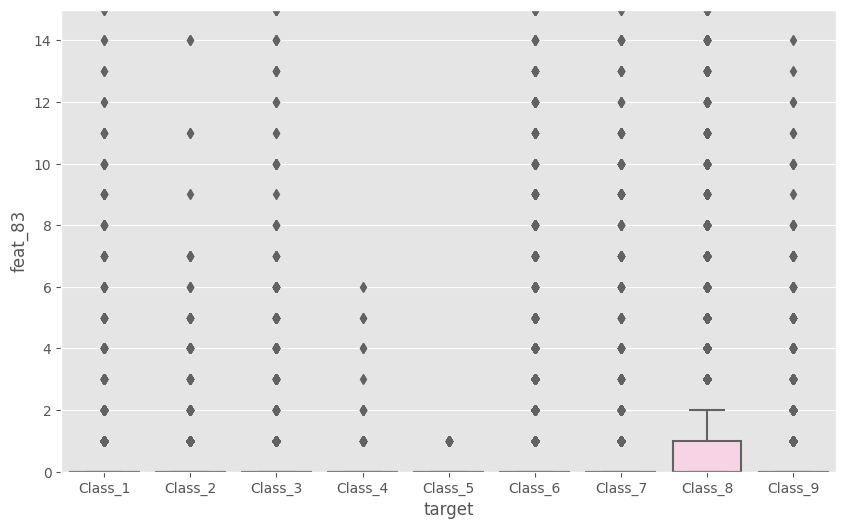

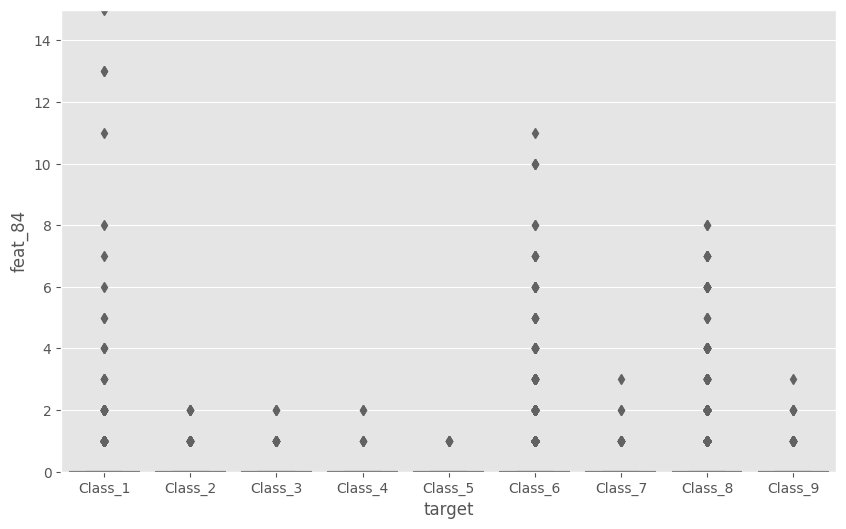

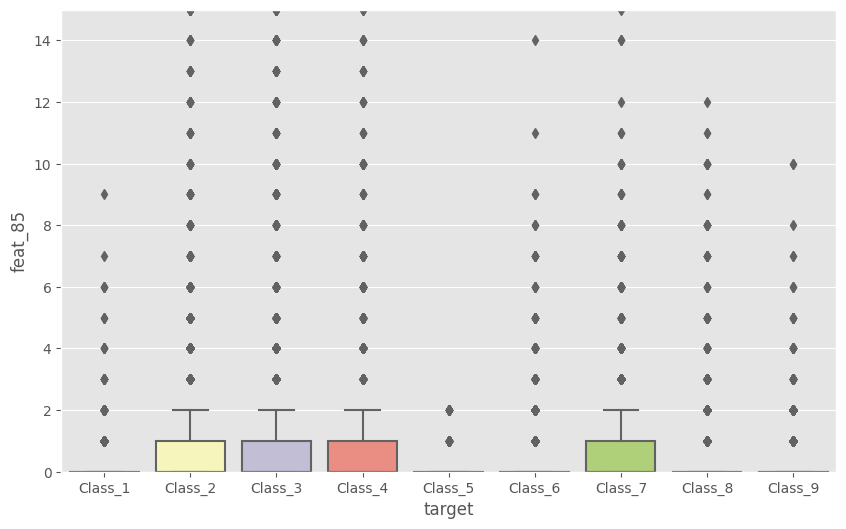

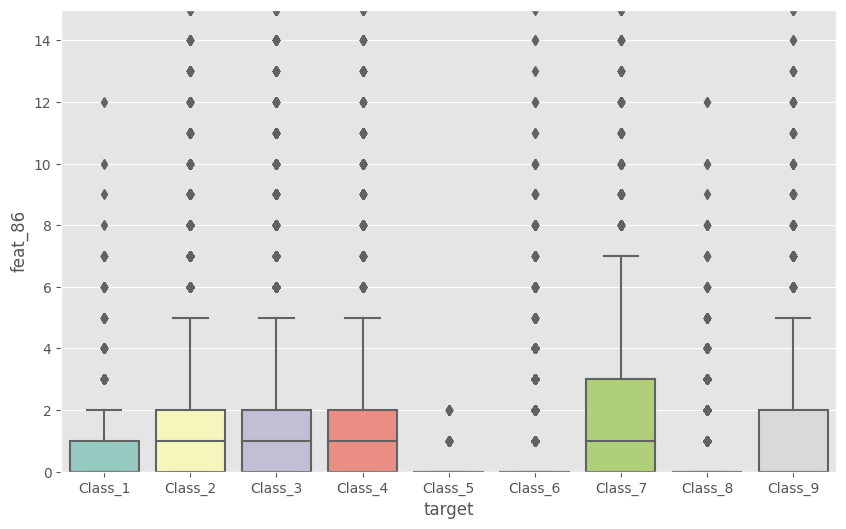

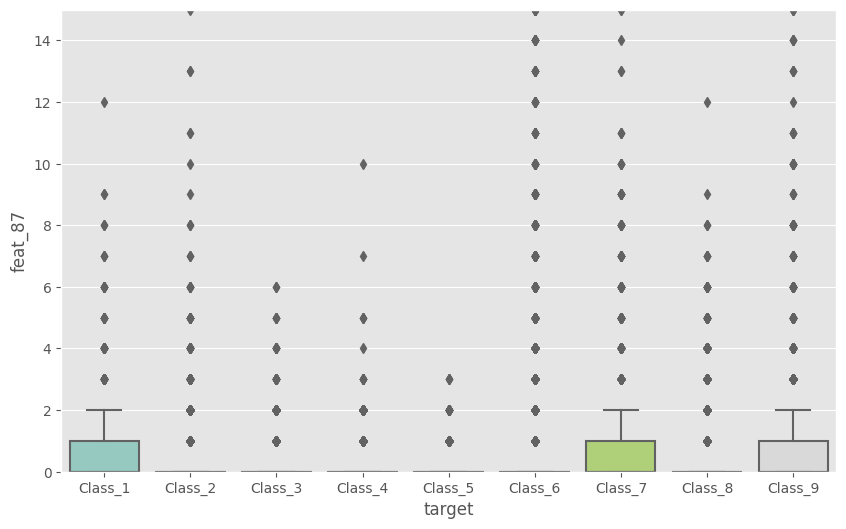

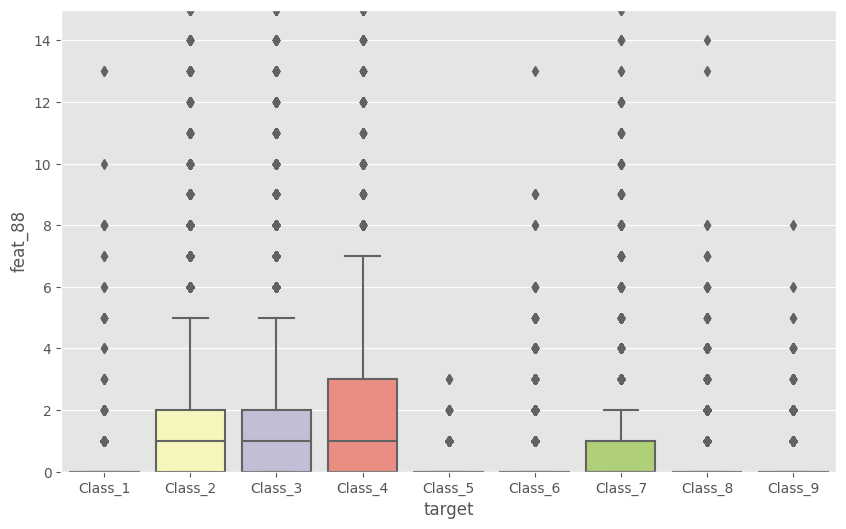

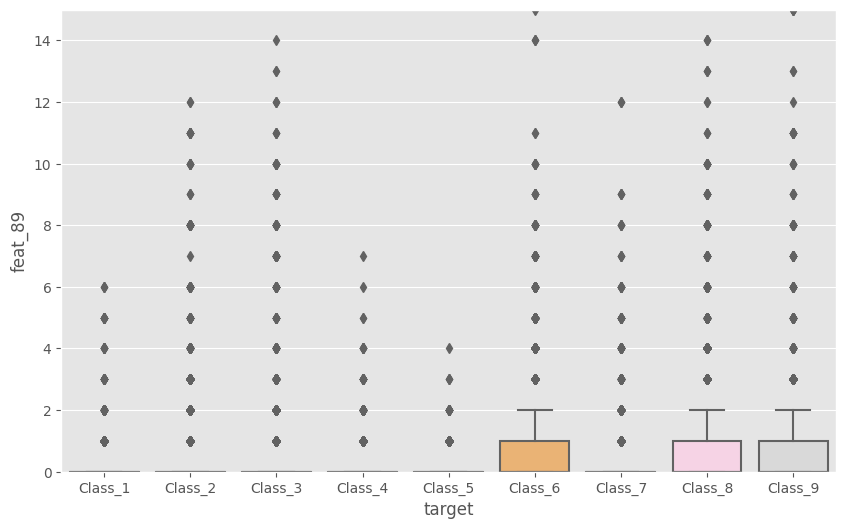

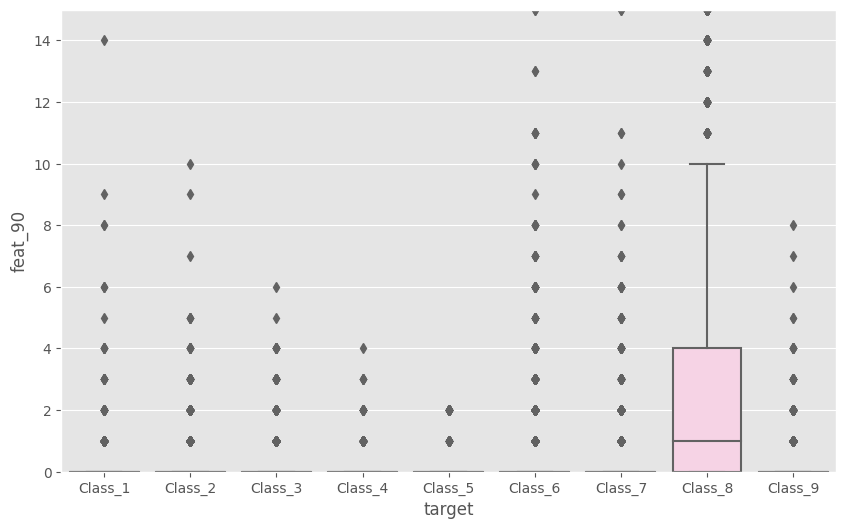

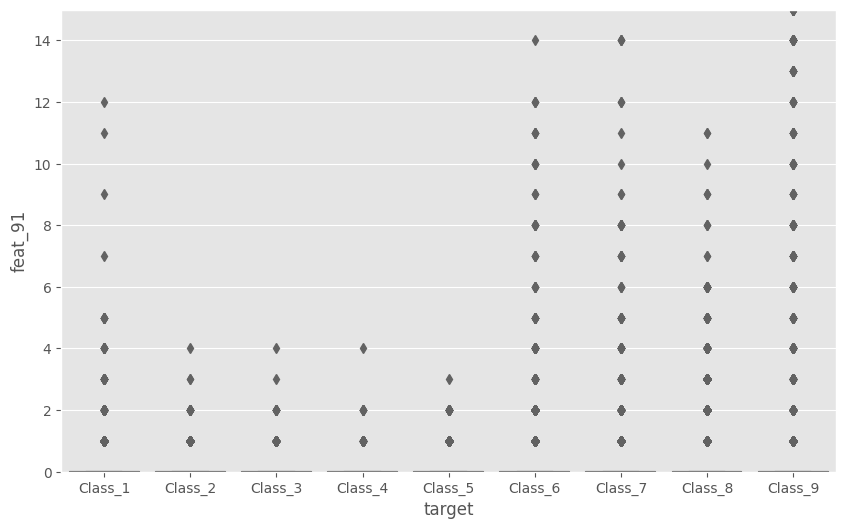

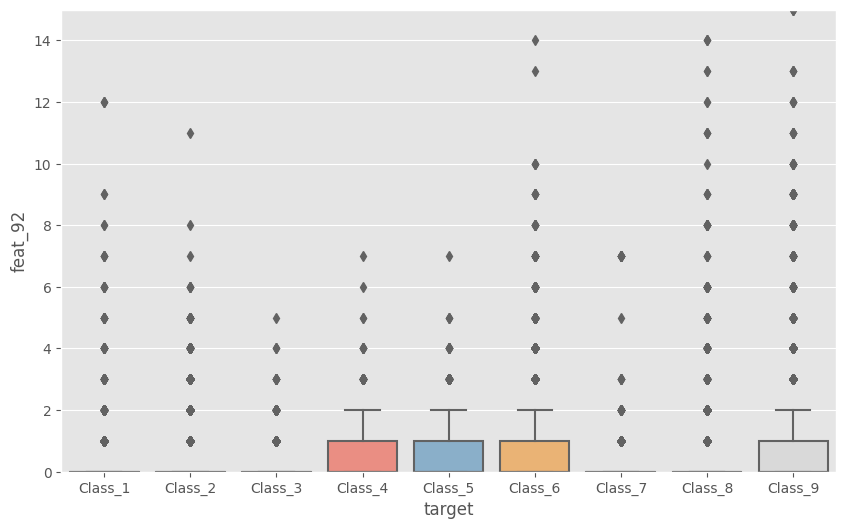

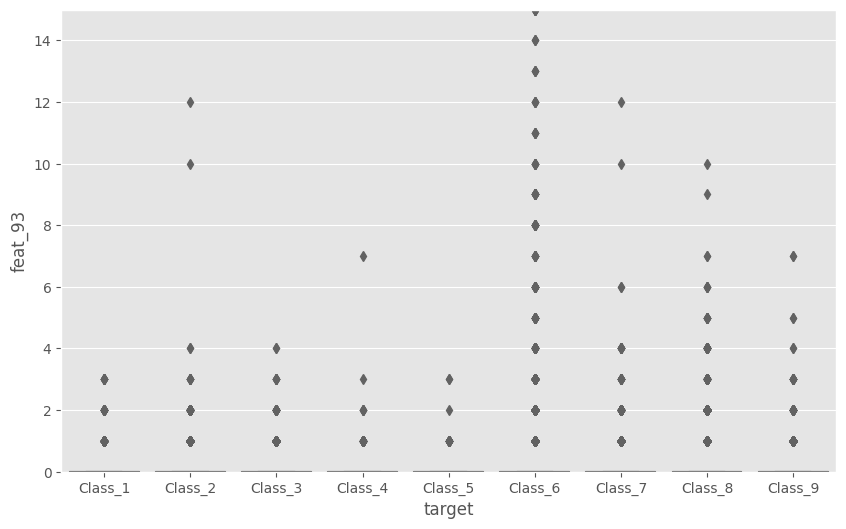

In [ ]:
import warnings
warnings.filterwarnings('ignore')
for name_feat in tqdm(features):
    plt.figure(figsize=(10,6))
    ax = sns.boxplot(x='target', y=name_feat, palette='Set3', data=df_train)
    ax.set_ylim([0, 15])

## Preprocesado de la Base de Datos

Aunque a los árboles no les suele afectar en demasía que las variables tengan diferentes rangos, vamos a tipificar los datos con *Z-Score* por si vamos a usar otros algoritmos **basados en distancias** supervisados, como KNN, o no supervisados, como clústering.

In [7]:
# Estandarizamos las BD
scaler = StandardScaler()
X_train = df_train_reduc[features].values
X_valid = df_valid_reduc[features].values
X_test = df_test_reduc[features].values
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Obtenemos los targets
y_train = df_train_reduc['target_num'].values
y_valid = df_valid_reduc['target_num'].values
y_test = df_test_reduc['target_num'].values

In [8]:
print("Verificamos que las TARGETS estan estratificadas")
print(np.round(np.bincount(y_train)/len(y_train),3))
print(np.round(np.bincount(y_valid)/len(y_valid),3))
print(np.round(np.bincount(y_test)/len(y_test),3))

Verificamos que las TARGETS estan estratificadas
[0.031 0.261 0.129 0.043 0.044 0.228 0.046 0.137 0.08 ]
[0.031 0.261 0.129 0.044 0.044 0.228 0.046 0.137 0.08 ]
[0.031 0.261 0.129 0.043 0.044 0.229 0.046 0.137 0.08 ]


## Modelos Binarios de la Clase 2. Ejemplo con Random Forest

Vamos a desarrollar modelos clasificadores binarios de la clase 2 (Class_2) frente a las otras clases existentes. Para ello, vamos a crear una clase binaria resultado de combinar todas las clases que no son 2 como clase 0, y si es la clase 2 como 1. 

In [9]:
y_train_class2 = np.zeros_like(y_train.copy(), dtype=int)
# La clase 2 tiene el valor 1
y_train_class2[y_train==1] = 1
y_valid_class2 = np.zeros_like(y_valid.copy(), dtype=int)
y_valid_class2[y_valid==1] = 1
y_test_class2 = np.zeros_like(y_test.copy(), dtype=int)
y_test_class2[y_test==1] = 1

print('Porcentaje en las tres BD')
print(np.round(np.bincount(y_train_class2)/len(y_train_class2),3))
print(np.round(np.bincount(y_valid_class2)/len(y_valid_class2),3))
print(np.round(np.bincount(y_test_class2)/len(y_test_class2),3))

Porcentaje en las tres BD
[0.739 0.261]
[0.739 0.261]
[0.739 0.261]


In [17]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

algoritmos=[LogisticRegression(),KNeighborsClassifier(), MLPClassifier(),DecisionTreeClassifier()]
modelos=[]
res=[]
for alg in algoritmos:
  alg.fit(X_train_scaled ,y_train_class2)
  auc_alg=roc_auc_score(y_valid_class2,alg.predict_proba(X_valid)[:,1])
  print(f'Algoritmo:{str(alg)} AUC= {auc_alg:0.4f}')
  res.append(dict(algoritmo=str(alg),auc=auc_alg))
  modelos.append(alg)
res=pd.DataFrame(res)



Algoritmo:LogisticRegression() AUC= 0.9027
Algoritmo:KNeighborsClassifier() AUC= 0.8852


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Algoritmo:MLPClassifier() AUC= 0.9157
Algoritmo:DecisionTreeClassifier() AUC= 0.6674


In [32]:
from sklearn.ensemble import VotingClassifier
modelo_vote=VotingClassifier([('LogisticRegression',modelos[0]),('KNeighborsClassifier',modelos[1]),('MLPClassifier',modelos[2])],voting='soft',n_jobs=-1,weights=[1.3,1.0,2.0])
modelo_vote.fit(X_train_scaled ,y_train_class2)
auc_alg=roc_auc_score(y_valid_class2,modelo_vote.predict_proba(X_valid)[:,1])
print(f'Algoritmo:{str(modelo_vote)} AUC= {auc_alg:0.4f}')


Algoritmo:VotingClassifier(estimators=[('LogisticRegression', LogisticRegression()),
                             ('KNeighborsClassifier', KNeighborsClassifier()),
                             ('MLPClassifier', MLPClassifier())],
                 n_jobs=-1, voting='soft', weights=[1.3, 1.0, 2.0]) AUC= 0.9145


In [42]:
from sklearn.ensemble import BaggingClassifier
modelo_logistico=KNeighborsClassifier()
modelo_logistico.fit(X_train_scaled ,y_train_class2)
auc_alg=roc_auc_score(y_valid_class2,modelo_logistico.predict_proba(X_valid)[:,1])
print(f'Algoritmo:{str(modelo_logistico)} AUC= {auc_alg:0.4f}')


modelo_bagging=BaggingClassifier(modelo_logistico,n_estimators=10, max_features=0.8)
modelo_bagging.fit(X_train_scaled ,y_train_class2)
auc_alg=roc_auc_score(y_valid_class2,modelo_bagging.predict_proba(X_valid)[:,1])
print(f'Algoritmo:{str(modelo_bagging)} AUC= {auc_alg:0.4f}')

Algoritmo:KNeighborsClassifier() AUC= 0.8852
Algoritmo:BaggingClassifier(estimator=KNeighborsClassifier(), max_features=0.8) AUC= 0.9006


In [43]:
from sklearn.ensemble import RandomForestClassifier
modelorf_=RandomForestClassifier(n_estimators=1400, n_jobs=-1, random_state=4567)
modelorf_.fit(X_train_scaled ,y_train_class2)
auc_alg=roc_auc_score(y_valid_class2,modelorf_.predict_proba(X_valid)[:,1])
print(f'Algoritmo:{str(modelorf_)} AUC= {auc_alg:0.4f}')

Algoritmo:RandomForestClassifier(n_estimators=1400, n_jobs=-1, random_state=4567) AUC= 0.8958


In [ ]:
from sklearn.ensemble import StackingClassifier
modelo_s=StackingClassifier([('LogisticRegression',modelos[0]),('KNeighborsClassifier',modelos[1]),('MLPClassifier',modelos[2])],voting='soft',n_jobs=-1,stack_method='')
modelo_s.fit(X_train_scaled ,y_train_class2)
auc_alg=roc_auc_score(y_valid_class2,modelo_s.predict_proba(X_valid)[:,1])
print(f'Algoritmo:{str(modelo_s)} AUC= {auc_alg:0.4f}')


### Métrica LogLoss

Inicialmente, vamos a buscar a hacer una exploración rápida con el algoritmo RandomForest que optimice el **logloss()**. 

Esta métrica es una de las métricas más usadas en clasificación.

En clasificación multiclase o multilabel, se define como:

![](https://iryndin.dev/img/logloss.gif)

donde 
- *N* = número de instancias.
- *M* = número de clases.
- $y_{ij}$ = probabilidad real de la clase $j$ correspondiente a la instancia $i$. Suele ser 1 o 0, aunque puede tener cualquier otro valor entre 0 y 1.
- $p_{ij}$ = probabilidad estimada por el clasificador para la clase $j$ de la instancia $i$.

Mientras que en clasificación binaria se suele usar:

![](https://miro.medium.com/max/656/1*wilGXrItaMAJmZNl6RJq9Q.png)

En ambos casos, cuanto más pequeño sea el valor de la métrica, mejor clasificación tendremos.

---

**Para profundizar ver los siguiente videos**: 

- *Understanding Binary Cross-Entropy / Log Loss in 5 minutes: a visual explanation*: https://www.youtube.com/watch?v=DPSXVJF5jIs
- *What is Log loss in machine learning|| How to calculate log loss in ML?*: https://www.youtube.com/watch?v=YbhzM2wxuBg

---

### Modelo RandomForest

Vamos a comenzar a estudiar **cómo modelizar el problema usando el algoritmo *RandomForestClassifier()* que es fácil de utilizar, potente y robusto**: . Más adelante, probaremos otros algoritmos más avanzados basados en Gradient Boosting Machines (GBM) como *LightGBM* o *XGBoost*.




---

**Para profundizar ver los siguiente videos**: 

- *Random Forest Algorithm Clearly Explained!*: https://www.youtube.com/watch?v=v6VJ2RO66Ag
- *Random Forest Classification | Machine Learning | Python*: https://www.youtube.com/watch?v=3NdH3egUjpM
- *StatQuest: Random Forests Part 1 - Building, Using and Evaluating*: https://www.youtube.com/watch?v=J4Wdy0Wc_xQ
- *StatQuest: Random Forests Part 2: Missing data and clustering*: https://www.youtube.com/watch?v=sQ870aTKqiM

---



  0%|          | 0/14 [00:00<?, ?it/s]

<Axes: xlabel='n_estimators'>

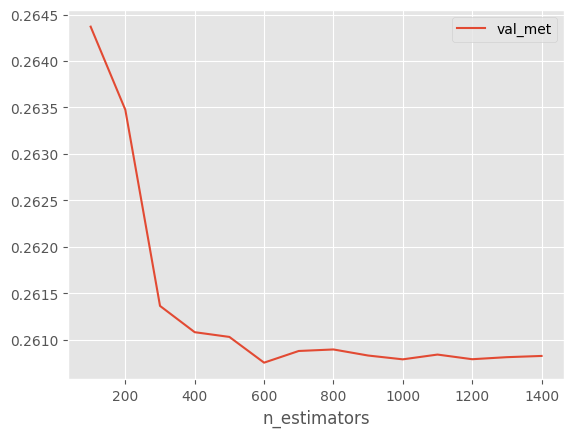

In [49]:
res = []
for n_estimators in tqdm(np.arange(100, 1500, 100)):
    rf_model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=4567)
    rf_model.fit(X_train_scaled, y_train_class2)
    val_met = log_loss(y_valid_class2, rf_model.predict_proba(X_valid_scaled)[:,1])
    res.append(dict(n_estimators=n_estimators, val_met=val_met))
res = pd.DataFrame(res)
res.plot(x='n_estimators', y='val_met')

In [51]:
best_model = res.iloc[res.val_met.argmin()]
print(best_model)
best_estimators = best_model.n_estimators.astype(int)

# Logloss con la de testeo
rf_model = RandomForestClassifier(n_estimators=best_estimators, n_jobs=-1, random_state=4567)
rf_model.fit(X_train_scaled, y_train_class2)
tst_met = log_loss(y_test_class2, rf_model.predict_proba(X_test_scaled)[:,1])
auc_alg=roc_auc_score(y_test_class2,rf_model.predict_proba(X_test_scaled)[:,1])
tst_met = log_loss(y_test_class2, rf_model.predict_proba(X_test_scaled)[:,1])
auc_alg=roc_auc_score(y_test_class2,rf_model.predict_proba(X_test_scaled)[:,1])
print("Logloss con la base de datos de testeo=", tst_met)
print("auc con la base de datos de testeo=", auc_alg)
print("F1 Score con la base de datos de testeo=", tst_met)
print("Kappa con la base de datos de testeo=", auc_alg)

n_estimators    600.000000
val_met           0.260754
Name: 5, dtype: float64
Logloss con la base de datos de testeo= 0.26022590420620706
auc con la base de datos de testeo= 0.9517928249645172


### Calibrado de las Probabilidades

Así mismo, podemos ver la diferencia de calibrar las predicciones del clasificador o no. Muchos algoritmos no presentan una probabilidad equilibrada y **cuando se usan métricas del tipo *LogLoss*, es necesario equilibrar la probabilidad de las predicciones**.

Por ejemplo, si el modelo estima una probabilidad del 80% para un caso determinado, el 80% de las predicciones deberían tener una probabilidad menor a esa. Muchos algoritmos que no son probabilisticos como, por ejemplo, los árboles o las máquinas vectores soporte, realizan unas estimaciones de probabilidad que no están equilibradas. 

*scikit-learn* dispone de la función *CalibratedClassifierCV()* que permite calcular un modelo y posteriormente [calibrar las probalidades](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py) con [regresión isotónica](https://en.wikipedia.org/wiki/Isotonic_regression) o regresión logística.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_calibration_curve_002.png)

---

**Para profundizar ver los siguiente videos**: 

- *Probability Calibration : Data Science Concepts*: https://www.youtube.com/watch?v=AunotauS5yI
- *Probability Calibration for Classification (Platt, isotonic, logistic and beta)*: https://www.youtube.com/watch?v=O5undKIazqs
- *Probability Calibration Workshop - Lesson 1*: https://www.youtube.com/watch?v=QUXfYgGlwtU

---

In [ ]:
def entrena_model_hold_out(model, X_train, y_train, X_valid, y_valid, calibra=True):
    np.random.seed(4567)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train)
        preds = calibrated_clf.predict_proba(X_valid)[:,1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:,1]
    metrica_log_loss = log_loss(y_valid, preds, eps=1e-15, normalize=True)
    return dict(log_loss=metrica_log_loss)

In [ ]:
%%time
# Comprobamos el grado de generalización del modelo con y sin calibración
rf_model = RandomForestClassifier(n_estimators=best_estimators, n_jobs=-1, random_state=4567)
metricas = entrena_model_hold_out(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=False)
print(f'Modelo Sin Calibrar LogLossVal={metricas["log_loss"]}')

metricas = entrena_model_hold_out(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=True)
print(f'Modelo Con Calibración LogLossVal={metricas["log_loss"]}')

Modelo Sin Calibrar LogLossVal=0.26022590420620706
Modelo Con Calibración LogLossVal=0.2500473681576325
CPU times: user 48.4 s, sys: 1.03 s, total: 49.4 s
Wall time: 1min 46s


In [ ]:
%%time
# Comprobamos el grado de generalización del modelo con y sin calibración
rf_model = RandomForestClassifier(n_estimators=best_estimators, n_jobs=-1, random_state=4567)
metricas = entrena_model_hold_out(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=False)
print(f'Modelo Sin Calibrar LogLossVal={metricas["log_loss"]}')

metricas = entrena_model_hold_out(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=True)
print(f'Modelo Con Calibración LogLossVal={metricas["log_loss"]}')

### EJERCICIO 1

Realizar las tareas siguientes y responder en un Informe PDF a las respuestas planteadas:

- Buscar el mejor modelo RF modificando *n_estimators* entre 100 y 1500 (con paso 100) que optimice las siguientes cinco métricas con la base de datos de validación: *Accuracy*, *F1-Score*, *Kappa*, *AUC* y *logloss*. Probar para cada métrica *sin calibrar* y *calibrando*.
- Rellenar **la tabla de abajo con el mejor número de estimadores (calibrando o sin calibrar)** y para cada una de las métricas (presentar el resultado para la base de datos de validación y la de testeo).
- Analizar la tabla y explicar los resultados.
- Explicar **el significado de cada métrica** y analizar por qué funciona mejor un método u otro para cada una de ellas.
- Pon ejemplos de la vida real de cuándo utilizar una métrica u otra.

NOTA: Utilizar la misma semilla aleatoria usada en los ejemplos. Pregunta: ¿Qué pasa si cambiamos la semilla aleatoria?  

    
| Métrica | *n_estimators* | Calibrado | Val | Tst |
|---------|-----------|-----------|-----|-----|
| ACC |100|Si|0.00|0.05|
| F1  |200|No|0.00|0.05|
| Kappa |150|Si|0.00|0.05|
| AUC   |200|No|0.00|0.05|
| LogLoss |600|Si|0.25004|0.26022|


  0%|          | 0/14 [00:00<?, ?it/s]

<Axes: xlabel='n_estimators'>

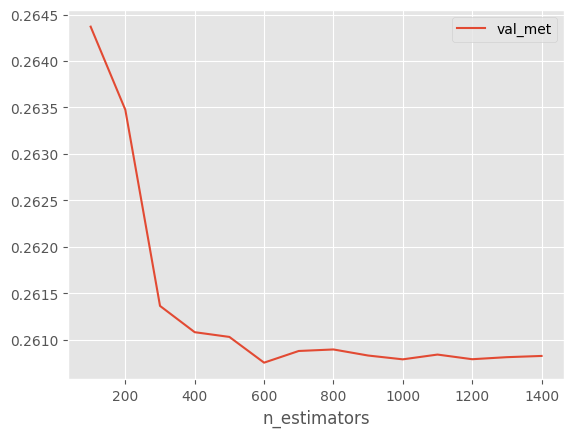

In [ ]:
res = []
for n_estimators in tqdm(np.arange(100, 1500, 100)):
    rf_model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=4567)
    rf_model.fit(X_train_scaled, y_train_class2)
    val_met = log_loss(y_valid_class2, rf_model.predict_proba(X_valid_scaled)[:,1])
    res.append(dict(n_estimators=n_estimators, val_met=val_met))
res = pd.DataFrame(res)
res.plot(x='n_estimators', y='val_met')

In [ ]:
best_model = res.iloc[res.val_met.argmin()]
print(best_model)
best_estimators = best_model.n_estimators.astype(int)

# Logloss con la de testeo
rf_model = RandomForestClassifier(n_estimators=best_estimators, n_jobs=-1, random_state=4567)
rf_model.fit(X_train_scaled, y_train_class2)
tst_met = log_loss(y_test_class2, rf_model.predict_proba(X_test_scaled)[:,1])
print("Logloss con la base de datos de testeo=", tst_met)

n_estimators    600.000000
val_met           0.260754
Name: 5, dtype: float64
Logloss con la base de datos de testeo= 0.26022590420620706


In [ ]:
def entrena_model_hold_out_ll(model, X_train, y_train, X_valid, y_valid, calibra=True):
    np.random.seed(4567)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train)
        preds = calibrated_clf.predict_proba(X_valid)[:,1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:,1]
    metrica_log_loss = log_loss(y_valid, preds, eps=1e-15, normalize=True)
    return dict(log_loss=metrica_log_loss)

In [ ]:
%%time
# Comprobamos el grado de generalización del modelo con y sin calibración
rf_model = RandomForestClassifier(n_estimators=best_estimators, n_jobs=-1, random_state=4567)
metricas = entrena_model_hold_out_ll(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=False)
print(f'Modelo Sin Calibrar LogLossVal={metricas["log_loss"]}')

metricas = entrena_model_hold_out_ll(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=True)
print(f'Modelo Con Calibración LogLossVal={metricas["log_loss"]}')

Modelo Sin Calibrar LogLossVal=0.26022590420620706
Modelo Con Calibración LogLossVal=0.2500473681576325
CPU times: user 48.9 s, sys: 1.58 s, total: 50.5 s
Wall time: 1min 39s


ACC


In [ ]:
res = []
for n_estimators in tqdm(np.arange(100, 1500, 100)):
    rf_model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=4567)
    rf_model.fit(X_train_scaled, y_train_class2)
    val_mete = train_evaluate_rf(y_valid_class2, rf_model.predict_proba(X_valid_scaled)[:,1])
    res.append(dict(n_estimators=n_estimators, val_met=val_met))
res = pd.DataFrame(res)
res.plot(x='n_estimators', y='val_met')

  0%|          | 0/14 [00:00<?, ?it/s]

TypeError: ignored

In [ ]:
best_model = res.iloc[res.val_met.argmin()]
print(best_model)
best_estimators = best_model.n_estimators.astype(int)

# Logloss con la de testeo
rf_model = RandomForestClassifier(n_estimators=best_estimators, n_jobs=-1, random_state=4567)
rf_model.fit(X_train_scaled, y_train_class2)
tst_met = accuracy_score(y_test_class2, rf_model.predict_proba(X_test_scaled)[:,1])
print("Logloss con la base de datos de testeo=", tst_met)

AttributeError: ignored

In [ ]:
def entrena_model_hold_out_accuracy(model, X_train, y_train, X_valid, y_valid, calibra=True):
    np.random.seed(4567)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train)
        preds = calibrated_clf.predict_proba(X_valid)[:,1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:,1]
    metrica_acc = accuracy_score(y_valid, preds>0.50)
    return dict(accuracy_score=metrica_acc)

In [ ]:
%%time
# Comprobamos el grado de generalización del modelo con y sin calibración
rf_model = RandomForestClassifier(n_estimators=best_estimators, n_jobs=-1, random_state=4567)
metricas = entrena_model_hold_out_accuracy(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=False)
print(f'Modelo Sin Calibrar accuracy_score={metricas["accuracy_score"]}')

metricas = entrena_model_hold_out_accuracy(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=True)
print(f'Modelo Con Calibración accuracy_score={metricas["accuracy_score"]}')

Modelo Sin Calibrar accuracy_score=0.883794849692921
Modelo Con Calibración accuracy_score=0.8788384872319793
CPU times: user 46.6 s, sys: 1.54 s, total: 48.1 s
Wall time: 1min 35s


F1

In [ ]:
def entrena_model_hold_out_f1(model, X_train, y_train, X_valid, y_valid, calibra=True):
    np.random.seed(4567)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train)
        preds = calibrated_clf.predict_proba(X_valid)[:,1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:,1]
    metrica_f1 = f1_score(y_valid, preds>0.50)
    return dict(f1_score=metrica_f1)

In [ ]:
%%time
# Comprobamos el grado de generalización del modelo con y sin calibración
rf_model = RandomForestClassifier(n_estimators=best_estimators, n_jobs=-1, random_state=4567)
metricas = entrena_model_hold_out_f1(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=False)
print(f'Modelo Sin Calibrar f1_score={metricas["f1_score"]}')

metricas = entrena_model_hold_out_f1(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=True)
print(f'Modelo Con Calibración f1_score={metricas["f1_score"]}')

Modelo Sin Calibrar f1_score=0.7727799431159802
Modelo Con Calibración f1_score=0.782558251957846
CPU times: user 47 s, sys: 1.53 s, total: 48.5 s
Wall time: 1min 34s


In [ ]:
def entrena_model_hold_out_kappa(model, X_train, y_train, X_valid, y_valid, calibra=True):
    np.random.seed(4567)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train)
        preds = calibrated_clf.predict_proba(X_valid)[:,1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:,1]
    metrica_f1 = f1_score(y_valid, preds>0.50)
    return dict(f1_score=metrica_f1)

In [ ]:
%%time
# Comprobamos el grado de generalización del modelo con y sin calibración
rf_model = RandomForestClassifier(n_estimators=best_estimators, n_jobs=-1, random_state=4567)
metricas = entrena_model_hold_out_f1(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=False)
print(f'Modelo Sin Calibrar f1_score={metricas["f1_score"]}')

metricas = entrena_model_hold_out_f1(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=True)
print(f'Modelo Con Calibración f1_score={metricas["f1_score"]}')

AUC


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, roc_auc_score, log_loss
from sklearn.calibration import CalibratedClassifierCV

# Definir listas para almacenar los resultados de las métricas
accuracy_scores = []
f1_scores = []
kappa_scores = []
auc_scores = []
logloss_scores = []

# Rango de valores para n_estimators
n_estimators_range = range(100, 1500, 100)

for n_estimators in n_estimators_range:
    # Crear el clasificador de Random Forest con el número de estimadores actual
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, random_state=4567)
    
    # Entrenar el modelo sin calibrar
    rf_clf.fit(X_train_scaled, y_train_class2)
    
    # Realizar predicciones en la base de datos de validación
    y_valid_pred = rf_clf.predict(X_valid_scaled)
    
    # Calcular las métricas sin calibrar
    accuracy = accuracy_score(y_valid_class2, y_valid_pred)
    f1 = f1_score(y_valid, y_valid_pred,average='macro')
    kappa = cohen_kappa_score(y_valid_class2, y_valid_pred)
    y_valid_pred_proba = rf_clf.predict_proba(X_valid_scaled)
    auc = roc_auc_score(y_valid_class2,modelorf_.predict_proba(X_valid)[:,1])
    
    
    # Almacenar los resultados de las métricas sin calibrar
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    kappa_scores.append(kappa)
    auc_scores.append(auc)
    
    
    # Entrenar el modelo con calibración
    calibrated_rf_clf = CalibratedClassifierCV(rf_clf, cv='prefit', method='isotonic')
    calibrated_rf_clf.fit(X_train_scaled, y_train)
    
    # Realizar predicciones calibradas en la base de datos de validación
    y_valid_pred_calibrated = calibrated_rf_clf.predict(X_valid_scaled)
    
    # Calcular las métricas calibradas
    accuracy_calibrated = accuracy_score(y_valid_class2, y_valid_pred_calibrated)
    f1_calibrated = f1_score(y_valid_class2, y_valid_pred_calibrated,average='macro')
    kappa_calibrated = cohen_kappa_score(y_valid_class2, y_valid_pred_calibrated)
    auc_calibrated = roc_auc_score(y_valid_class2,y_valid_pred_calibrated[:,1])

    
    # Almacenar los resultados de las métricas calibradas
    accuracy_scores.append(accuracy_calibrated)
    f1_scores.append(f1_calibrated)
    kappa_scores.append(kappa_calibrated)
    auc_scores.append(auc_calibrated)


# Encontrar el índice del mejor resultado para cada métrica sin calibrar
best_accuracy_index = np.argmax(accuracy_scores[:len(n_estimators_range)])
best_f1_index = np.argmax(f1_scores[:len(n_estimators_range)])
best_kappa_index = np.argmax(kappa_scores[:len(n_estimators_range)])
best_auc_index = np.argmax(auc_scores[:len(n_estimators_range)])


# Encontrar el índice del mejor resultado para cada métrica calibrada
best_accuracy_index_calibrated = np.argmax(accuracy_scores[len(n_estimators_range):])
best_f1_index_calibrated = np.argmax(f1_scores[len(n_estimators_range):])
best_kappa_index_calibrated = np.argmax(kappa_scores[len(n_estimators_range):])
best_auc_index_calibrated = np.argmax(auc_scores[len(n_estimators_range):])


# Imprimir los mejores resultados para cada métrica sin calibrar
print('Mejor modelo sin calibrar:')
print('Accuracy:', accuracy_scores[best_accuracy_index])
print('F1-Score:', f1_scores[best_f1_index])
print('Kappa:', kappa_scores[best_kappa_index])
print('AUC:', auc_scores[best_auc_index])


# Imprimir los mejores resultados para cada métrica calibrada
print('Mejor modelo calibrado:')
print('Accuracy:', accuracy_scores[best_accuracy_index_calibrated + len(n_estimators_range)])
print('F1-Score:', f1_scores[best_f1_index_calibrated + len(n_estimators_range)])
print('Kappa:', kappa_scores[best_kappa_index_calibrated + len(n_estimators_range)])
print('AUC:', auc_scores[best_auc_index_calibrated + len(n_estimators_range)])


IndexError: ignored

### EJERCICIO 2

Repetir el ejercicio anterior incluyendo los siguientes algoritmos (tocando solo un hiperparámetro):
- LogisticRegression(*C* = cost)
- KNeighborsClassifier(*n_neighbors* = num_vecinos)
- MLPClassifier(*hidden_layer_sizes* = (num_neuronas,), *solver* = 'lbfgs')
- DecisionTreeClassifier(*max_depth* = max_profundidad)
- SVC(*C*= cost, *kernel*='rbf')


**Rellenar una tabla indicando para cada algoritmo el valor obtenido de la métrica y si ha sido conveniente calibrar o no (entre parentesis).**

| Métrica | RF(NO) | LOG | KNN | MLP | DTC | SVC |
|---------|-----|-----|-----|-----|----|-----|
| ACC     |0.00(si)|0.00(si)|0.00(si)|0.00(si)|0.00(no)|0.00(no)|
| F1     |0.00(si)|0.00(si)|0.00(si)|0.00(si)|0.00(no)|0.00(no)|
| Kappa     |0.00(si)|0.00(si)|0.00(si)|0.00(si)|0.00(no)|0.00(no)|
| AUC     |0.00(si)|0.00(si)|0.00(si)|0.00(si)|0.00(no)|0.00(no)|
| LogLoss     |0.00(si)|0.00(si)|0.00(si)|0.00(si)|0.00(no)|0.00(no)|


Analiza la tabla y extrae tus propias conclusiones.



## Balanceo de Clases

Algunas métricas pueden mejorarse mediante el balanceo de las clases que consiste en **equilibrar el número de casos de cada clase**:

- Sobremuestreando la clase minoritaria (*oversampling*).
- Submuestrando la clase mayoritaria (*subsampling*).
- Creando nuevos casos de la clase minoritaria mediante algoritmos como SMOTE.

ref1: https://www.kaggle.com/code/residentmario/undersampling-and-oversampling-imbalanced-data/notebook

Otra forma, más habitual y eficiente, **es aplicar diferentes pesos a cada una de las clases**, de forma que la clase minoritaria tenga mayor peso que la mayoritaria a la hora de construir el modelo (habitualmente la función *loss* del algoritmo incorpora los pesos de cada clase en la propia fórmula de modo que el balanceo se realiza directamente al calcular dicho coste).

Vamos a ver un ejemplo para mejora el *accuracy*. Como se puede ver en la gráfica, la base de datos está desbalanceada.

False    18303
True      6449
Name: is_class_2, dtype: int64

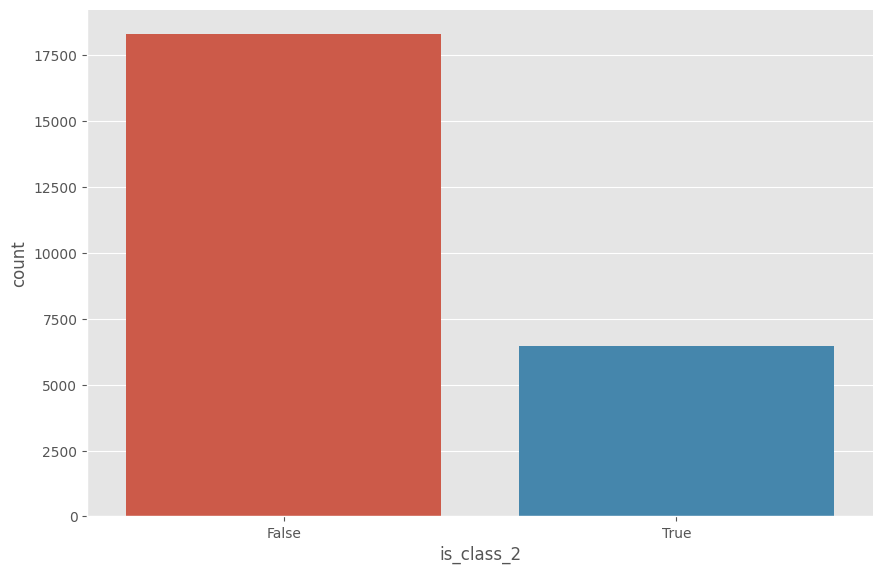

In [ ]:
X_tmp = df_train_reduc.copy()
X_tmp['is_class_2'] = (y_train_class2==1)
g = sns.catplot(x='is_class_2', data=X_tmp, kind='count')
g.fig.set_size_inches(10,6)
X_tmp['is_class_2'].value_counts()

In [ ]:
def entrena_model_hold_out(model, X_train, y_train, X_valid, y_valid, calibra=True):
    np.random.seed(4567)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train_class2)
        preds = calibrated_clf.predict_proba(X_valid)[:,1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:,1]
    metrica_log_loss = log_loss(y_valid, preds, eps=1e-15, normalize=True)
    metrica_acc = accuracy_score(y_valid, preds>0.50)
    return dict(log_loss=metrica_log_loss, acc=metrica_acc)

Vamos a probar Balancear las clases con la librería *imblearn* usando el modelo Logistico. 

**Es importante entender que la base de datos de validación y testeo NO hay que modificarlas, solo la de entrenamiento. Si modificamos las bases de datos de validación o testeo estamos desvirtuando toda la validación de los modelos**

In [ ]:
 !python -m pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
log_model = LogisticRegression(C=1, random_state=1234, n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico Sin Balancear ACC={metricas["acc"]}')

Modelo Logistico Sin Balancear ACC=0.839258780435251


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
oversamp = RandomOverSampler(random_state=1234)
X_train_resampled, y_train_resampled = oversamp.fit_resample(X_train_scaled, y_train_class2)
print('Numero de casos de cada clase:', np.bincount(y_train_resampled))

log_model = LogisticRegression(C=1, random_state=1234, n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico con OverSampling ACC={metricas["acc"]}')

Numero de casos de cada clase: [18303 18303]
Modelo Logistico con OverSampling ACC=0.8198664081017022


In [ ]:
oversamp = RandomUnderSampler(random_state=1234)
X_train_resampled, y_train_resampled = oversamp.fit_resample(X_train_scaled, y_train_class2)
print('Numero de casos de cada clase:', np.bincount(y_train_resampled))

log_model = LogisticRegression(C=1, random_state=1234, n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico con UnderSampling ACC={metricas["acc"]}')

Numero de casos de cada clase: [6449 6449]
Modelo Logistico con UnderSampling ACC=0.818304244774833


Vemos que parece que NO mejora el ACC con ninguno de los dos. Quizás balancear al 100% las clases es demasiado y puede ser interesante hacer un balanceo con un ratio que no sea del 100%. Para ello se puede usar la opción *sampling_strategy* que permite indicar el número de casos de cada clase que queremos que muestree.

Incrementamos levemente el número de casos de la clase 2 (clase minoritaria)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
oversamp = RandomOverSampler(random_state=1234, sampling_strategy={0:18303, 1:6500})
X_train_resampled, y_train_resampled = oversamp.fit_resample(X_train_scaled, y_train_class2)
print('Numero de casos de cada clase:', np.bincount(y_train_resampled))

log_model = LogisticRegression(C=1, random_state=1234, n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico con un ligero OverSampling ACC={metricas["acc"]}')

Numero de casos de cada clase: [18303  6500]
Modelo Logistico con un ligero OverSampling ACC=0.8393126481361776


Existen otros métodos como SMOTE que permite realizar nuevas instancias de la clase minoritaria en base a búsqueda por K-Vecinos (ver ejemplos en https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).


Otra forma, muy utilizada e incluso más eficiente, es la del siguiente ejemplo donce vemos otra forma de tratar el desbalanceo mediante el uso de pesos diferentes para cada clase.        

In [ ]:
%%time
# Se asigna un peso a cada clase inversamente proporcional a la fecuencia de cada clase
print('Pesos asignados a cada clase:',len(y_train_class2)/(2*np.bincount(y_train_class2)))
log_model = LogisticRegression(C=1, class_weight='balanced',random_state=4567,n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico ajustando los Pesos ACC={metricas["acc"]}')

Pesos asignados a cada clase: [0.6761733  1.91905722]
Modelo Logistico ajustando los Pesos ACC=0.8197048049989226
CPU times: user 38.7 ms, sys: 14 ms, total: 52.7 ms
Wall time: 1.87 s


Igual que en el caso anterior, los pesos pueden ser ajustados manualmente para que el balanceo sea menos drástico.

In [ ]:
%%time
# Se asigna un peso a cada clase inversamente proporcional a la fecuencia de cada clase
log_model = LogisticRegression(C=1, class_weight={0:0.6761, 1:0.7}, random_state=4567,n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico ajustando los Pesos ACC={metricas["acc"]}')

Modelo Logistico ajustando los Pesos ACC=0.8393665158371041
CPU times: user 34 ms, sys: 40.8 ms, total: 74.8 ms
Wall time: 1.37 s


### EJERCICIO  3

Elige el mejor algoritmo para cada una de las métricas obtenidas en la tabla del ejercicio 2 e intenta mejorar los resultados obtenidos con alguna de las técnicas de muestreo anteriores. Rellena la siguiente tabla.



| Métrica | Algoritmo | Original | Nuevo | Método Usado |
|---------|-----------|----------|-------|--------------|
| ACC     |MLP|0.00|0.05|Undersampling|
| F1     |SVC|0.00|0.05|Smote|
| Kappa     |LOG|0.00|0.05|Undersampling (0=10000,1=7000)|
| AUC     |DTC|0.00|0.05|Oversampling|
| LogLoss     |MLP|0.00|0.05|No se ha podido|

## ENTREGA

**Todos los pasos realizados deberán ser explicados con detalle en un documento PDF. El nombre del archivo deberá incluir lo siguiente 'PROYECTO3_NombreDelAlumnoSinAcentos.PDF'. Ejemplo: PROYECTO3_PEPITO_PEREZ.PDF**

Si usas Colab, recuerde guardar sus cambios en su repositorio utilizando la opción "Save a copy in GitHub..." del menú File.